# Ablation study of transcript parts

Study of which parts of the transcript are most harmful when ablated.

In [59]:
import os
import sys
import shutil
import random
import glob
import multiprocessing
import socket
import pickle
import importlib
import itertools
import functools
import collections
import logging
logging.basicConfig(level=logging.INFO)

import tqdm

import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

from statsmodels.stats.multitest import multipletests

from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics

SRC_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'rnagps')
assert os.path.isdir(SRC_DIR)
sys.path.append(SRC_DIR)
import data_loader
import model_utils
import plotting_utils
import kmer
import pwm
import seq
import fasta
import interpretation

PLOT_DIR = os.path.join(os.path.dirname(SRC_DIR), "plots")
assert os.path.isdir(PLOT_DIR)
plt.style.use(['default', os.path.join(SRC_DIR, 'seaborn-paper-custom.mplstyle')])

np.random.seed(27492)
SEED = 27492

## Baseline

Full transcripts model as a baseline

In [2]:
importlib.reload(data_loader)
K_FOLD = 5
train_dataset = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
valid_dataset = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
test_dataset = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], addtl_negatives=False)
train_data = data_loader.load_data_as_np(train_dataset)
valid_data = data_loader.load_data_as_np(valid_dataset)
test_data = data_loader.load_data_as_np(test_dataset)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [3]:
print(train_data[0].shape)
print(train_data[1].shape)

(2928, 4032)
(2928, 8)


Validation AUROC: 0.7467255385060354
Validation AUPRC: 0.4103248524326642


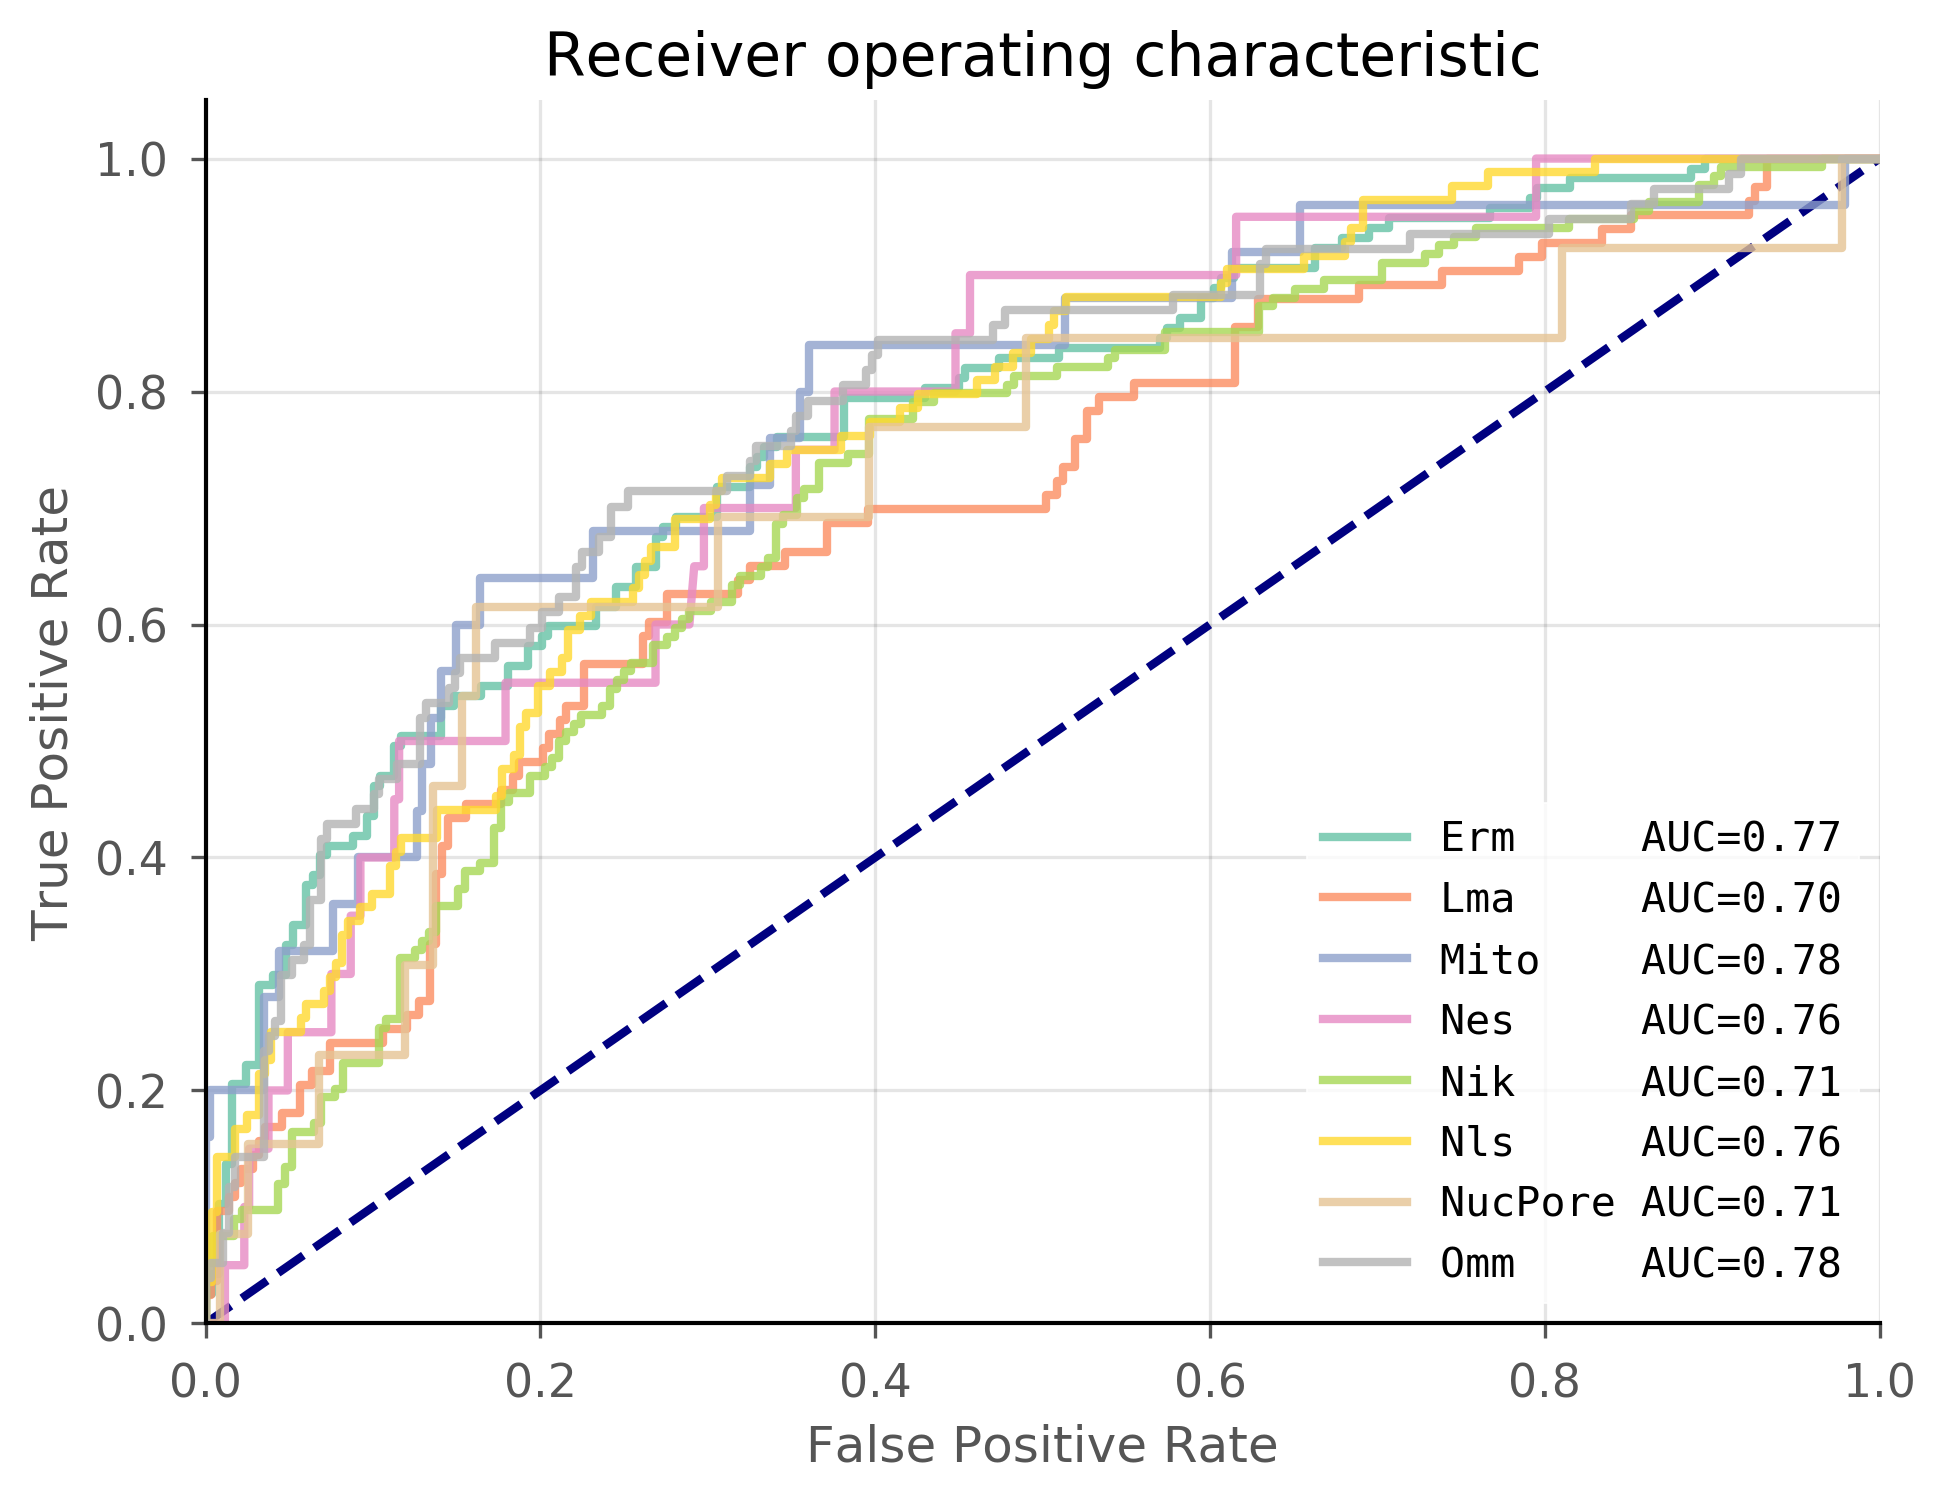

In [4]:
# Random forest classifier
rf_kwargs = {
    'n_estimators': 300,
    'criterion': 'entropy',
    'max_depth': 100,
    'min_samples_leaf': 0.001,
    'max_features': 'sqrt',
    'class_weight': None,
    'n_jobs': 32,
    'random_state': 39282,
}

rf_model, rf_per_class_perf, rf_overall_perf = model_utils.multi_train(
    RandomForestClassifier(**rf_kwargs),
    train_data,
    valid_data,
    verbose=False
)
print("Validation AUROC: {}".format(rf_overall_perf.auroc))
print("Validation AUPRC: {}".format(rf_overall_perf.auprc))
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset.compartments, rf_per_class_perf)}
)

In [5]:
rf_per_class_test_perf = model_utils.generate_multiclass_perf(
    test_data[1],
    rf_model.predict_proba(test_data[0]),
    num_classes=8,
)

## Ablate 5' UTR

In [6]:
importlib.reload(data_loader)
train_dataset_no5 = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['cds', 'u3'], addtl_negatives=False)
valid_dataset_no5 = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['cds', 'u3'], addtl_negatives=False)
test_dataset_no5 = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['cds', 'u3'], addtl_negatives=False)
train_data_no5 = data_loader.load_data_as_np(train_dataset_no5)
valid_data_no5 = data_loader.load_data_as_np(valid_dataset_no5)
test_data_no5 = data_loader.load_data_as_np(test_dataset_no5)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [7]:
print(train_dataset_no5.trans_parts)
print(train_data_no5[0].shape)
print(train_data_no5[1].shape)

['cds', 'u3']
(2928, 2688)
(2928, 8)


Validation AUROC: 0.7477616659788615
Validation AUPRC: 0.42143793171704647


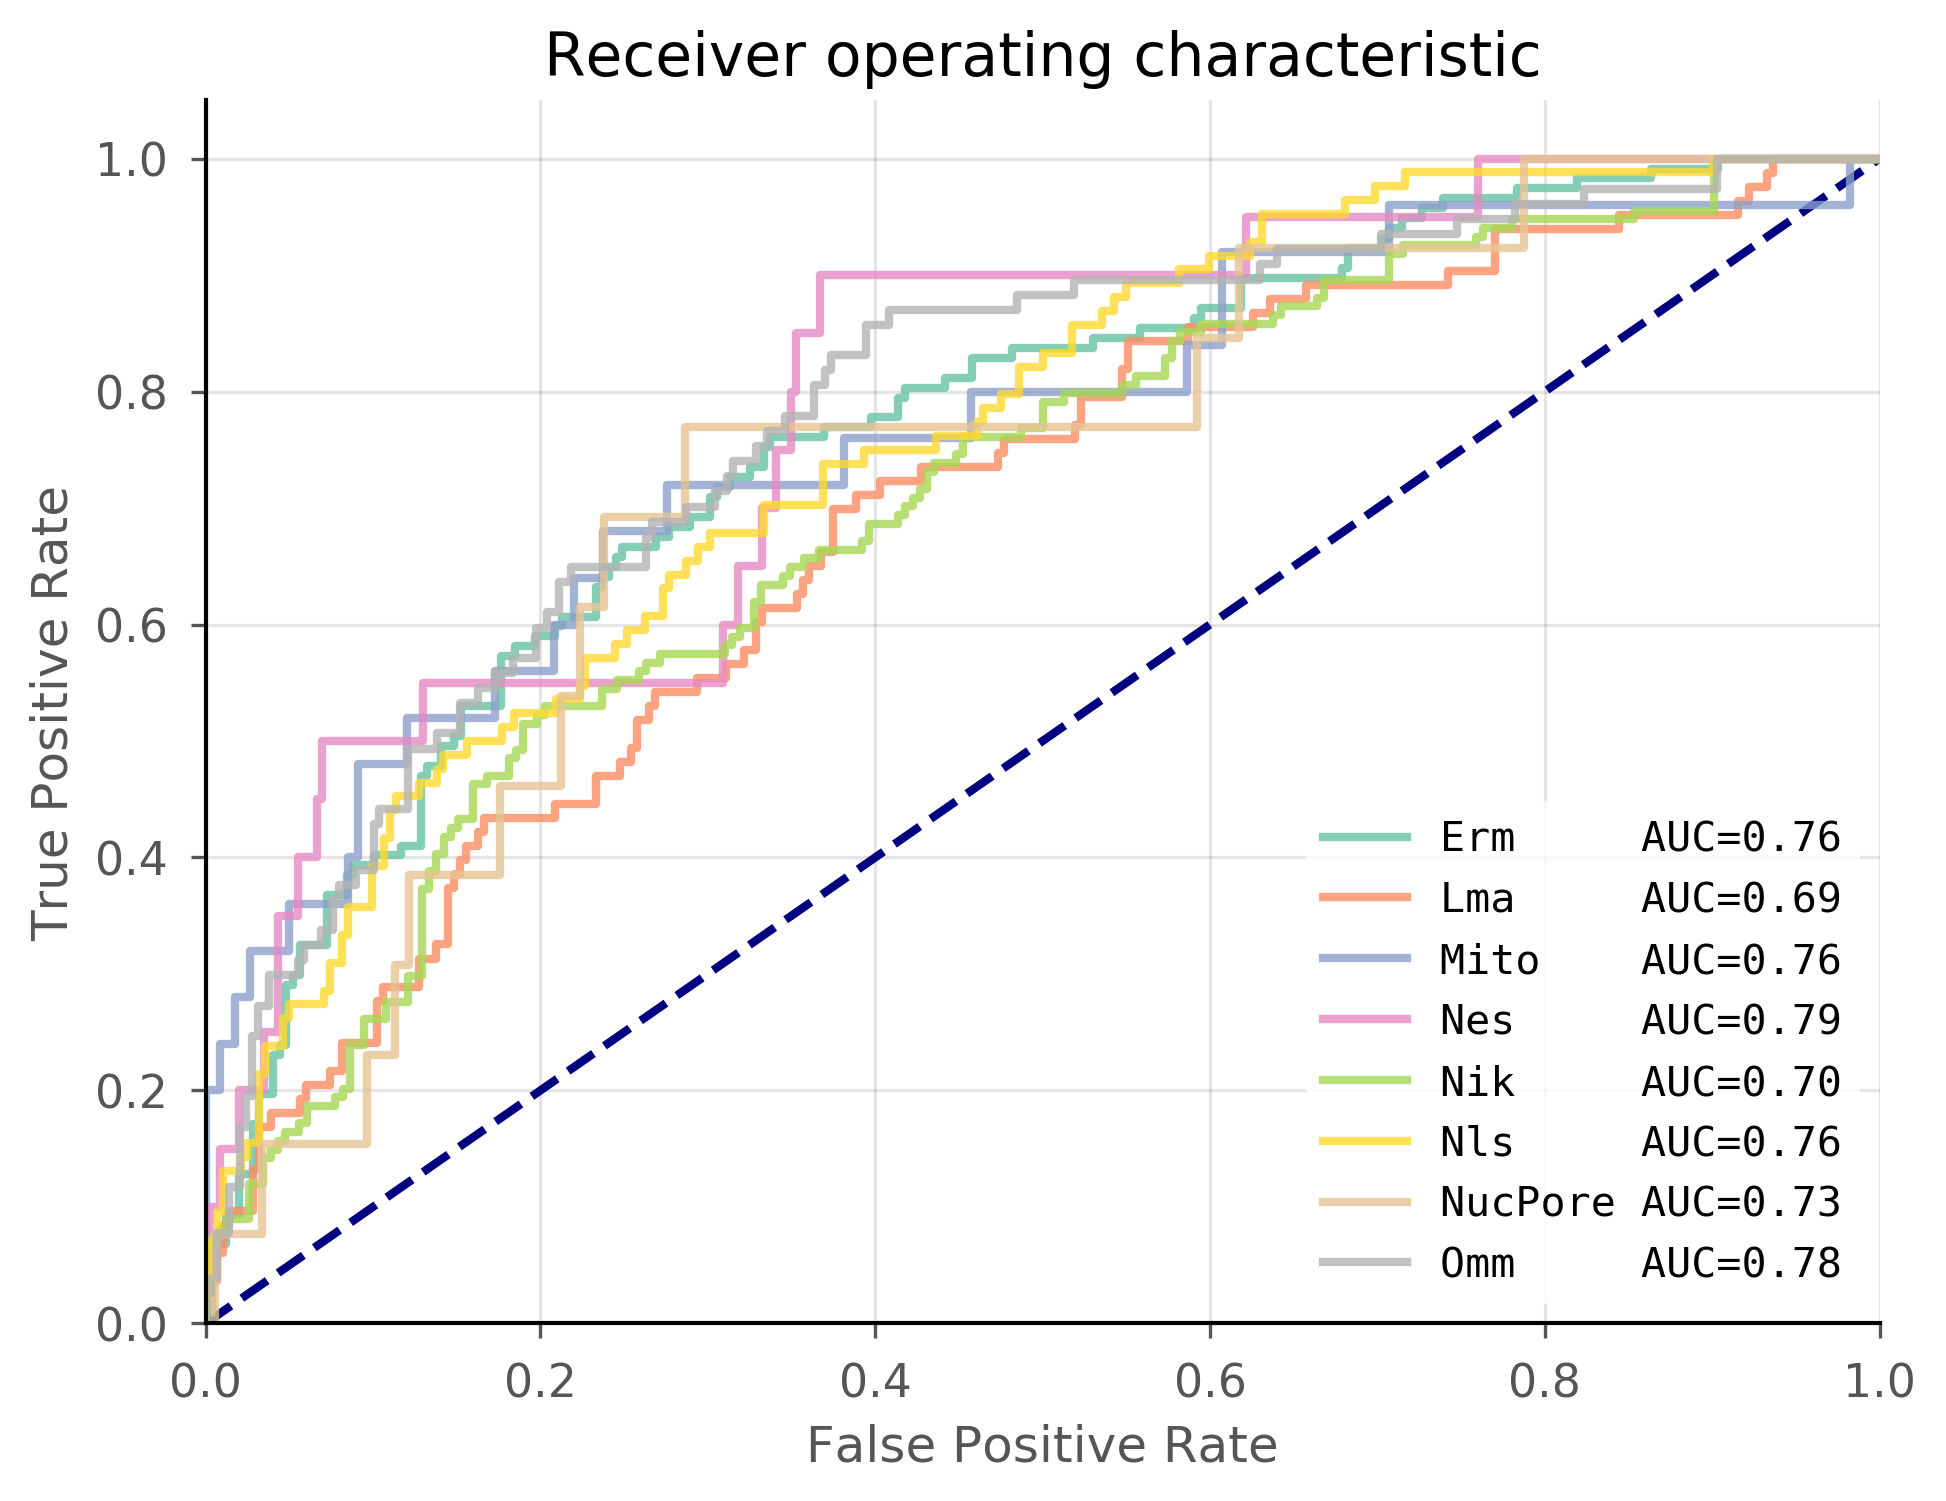

In [8]:
rf_model_no5, rf_per_class_perf_no5, rf_overall_perf_no5 = model_utils.multi_train(
    RandomForestClassifier(**rf_kwargs),
    train_data_no5,
    valid_data_no5,
    verbose=False
)
print("Validation AUROC: {}".format(rf_overall_perf_no5.auroc))
print("Validation AUPRC: {}".format(rf_overall_perf_no5.auprc))
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset_no5.compartments, rf_per_class_perf_no5)}
)

In [9]:
rf_per_class_test_perf_no5 = model_utils.generate_multiclass_perf(
    test_data_no5[1],
    rf_model_no5.predict_proba(test_data_no5[0]),
    num_classes=8,
)

## Ablate CDS

In [10]:
importlib.reload(data_loader)
train_dataset_nocds = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['u5', 'u3'], addtl_negatives=False)
valid_dataset_nocds = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['u5', 'u3'], addtl_negatives=False)
test_dataset_nocds = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['u5', 'u3'], addtl_negatives=False)
train_data_nocds = data_loader.load_data_as_np(train_dataset_nocds)
valid_data_nocds = data_loader.load_data_as_np(valid_dataset_nocds)
test_data_nocds = data_loader.load_data_as_np(test_dataset_nocds)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [11]:
print(train_dataset_nocds.trans_parts)
print(train_data_nocds[0].shape)
print(train_data_nocds[1].shape)

['u5', 'u3']
(2928, 2688)
(2928, 8)


Validation AUROC: 0.6899702914644867
Validation AUPRC: 0.35792959852765155


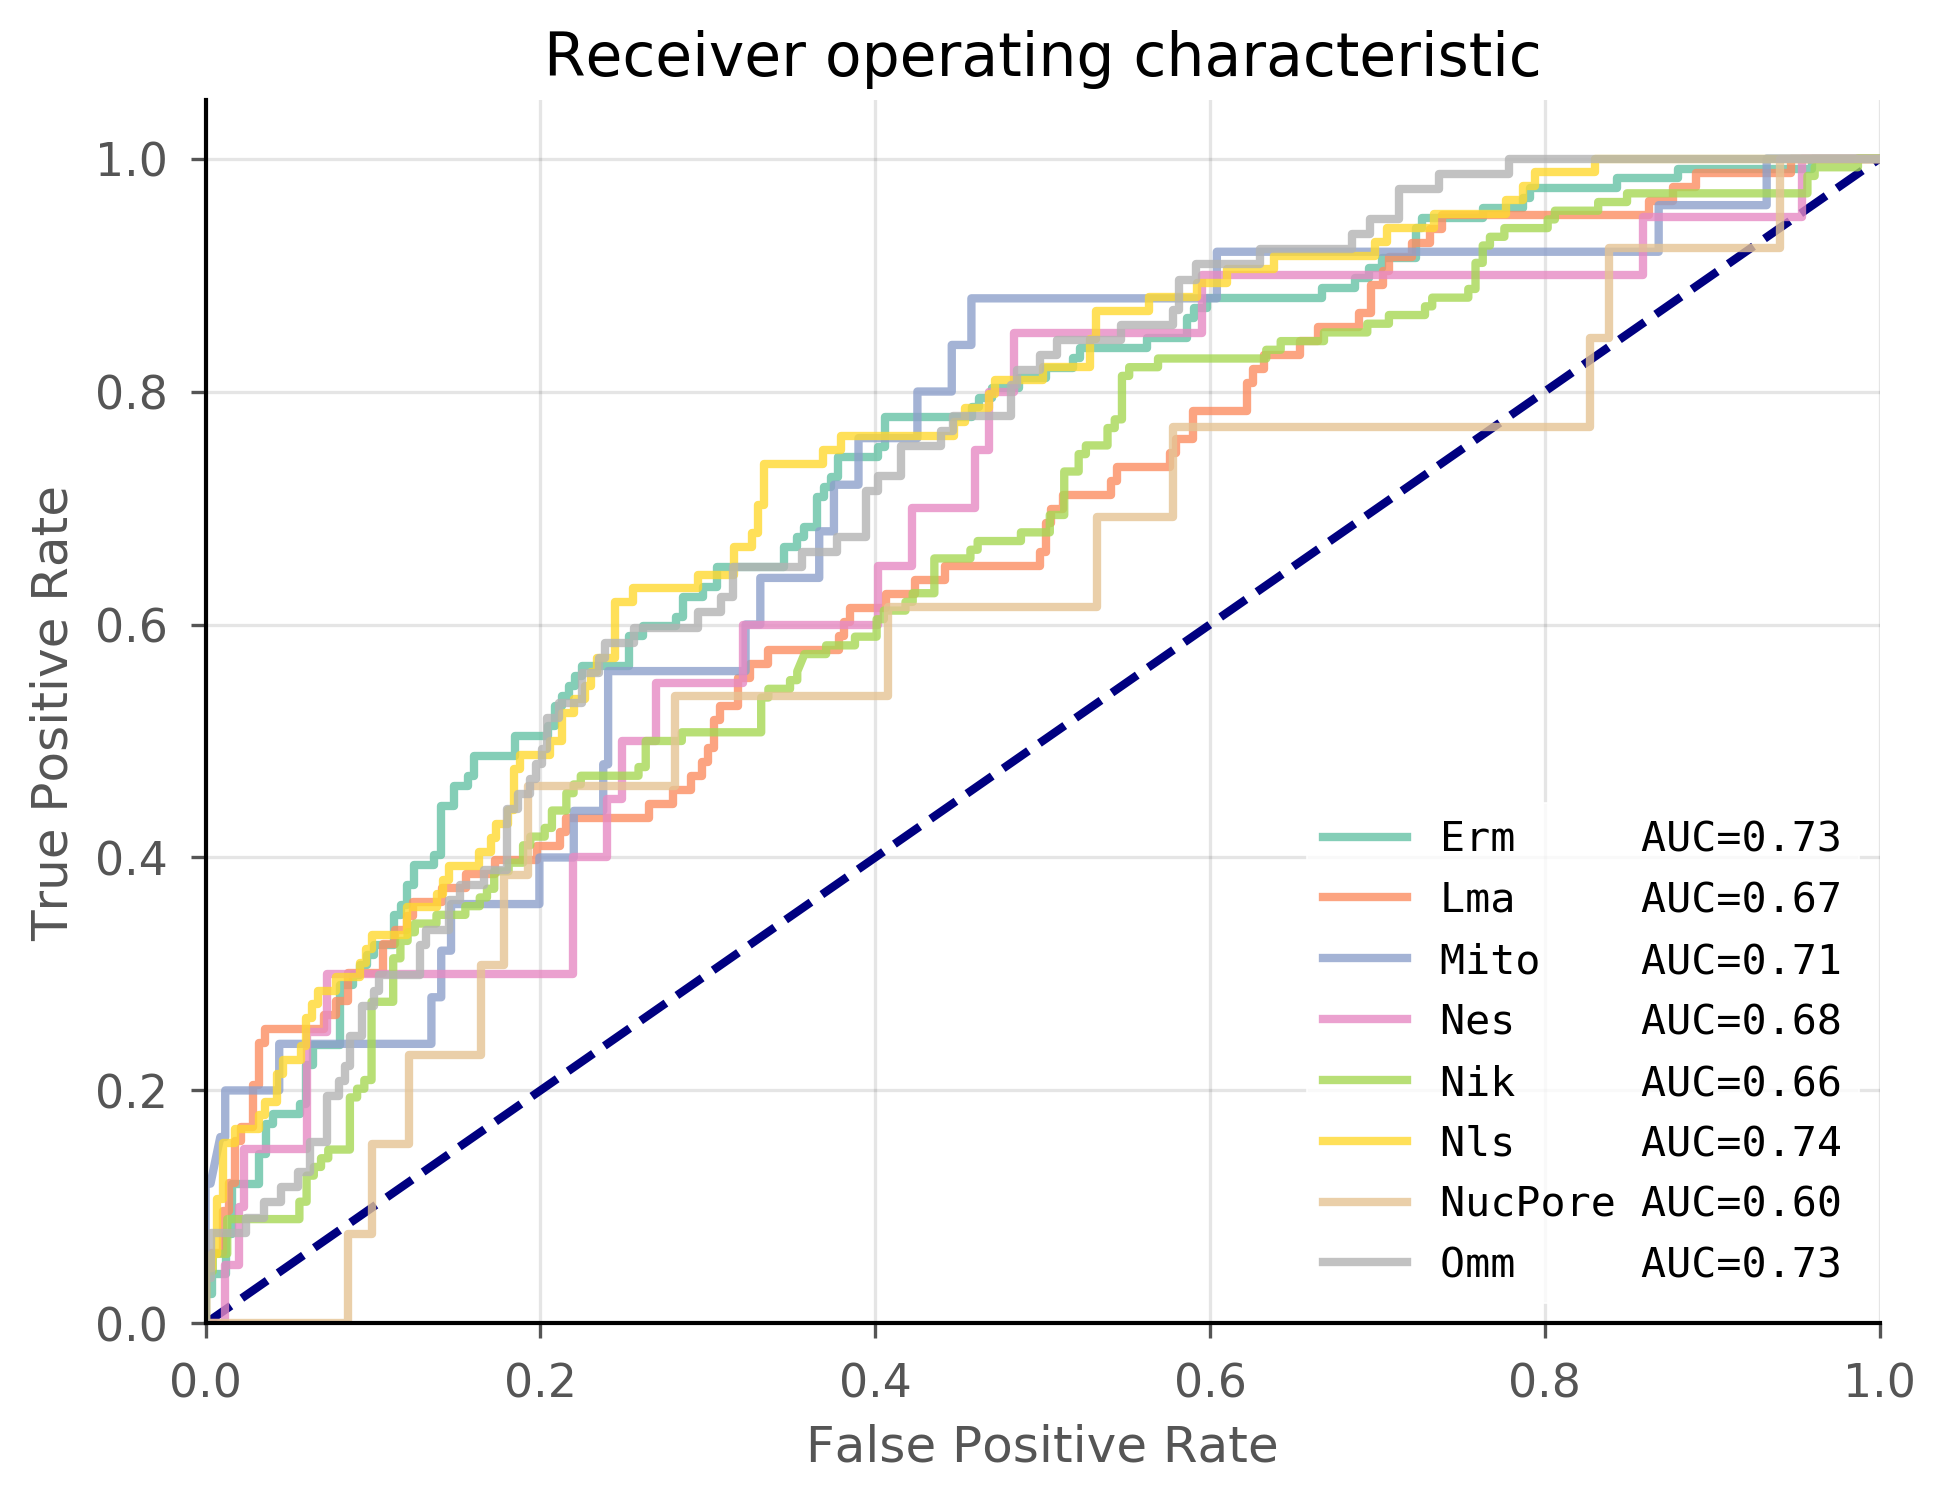

In [12]:
rf_model_nocds, rf_per_class_perf_nocds, rf_overall_perf_nocds = model_utils.multi_train(
    RandomForestClassifier(**rf_kwargs),
    train_data_nocds,
    valid_data_nocds,
    verbose=False
)
print("Validation AUROC: {}".format(rf_overall_perf_nocds.auroc))
print("Validation AUPRC: {}".format(rf_overall_perf_nocds.auprc))
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset_nocds.compartments, rf_per_class_perf_nocds)}
)

In [13]:
rf_per_class_test_perf_nocds = model_utils.generate_multiclass_perf(
    test_data_nocds[1],
    rf_model_nocds.predict_proba(test_data_nocds[0]),
    num_classes=8,
)

## Ablate 3' UTR

In [14]:
importlib.reload(data_loader)
train_dataset_no3 = data_loader.LocalizationClassificationKmers("train", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['u5', 'cds'], addtl_negatives=False)
valid_dataset_no3 = data_loader.LocalizationClassificationKmers("valid", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['u5', 'cds'], addtl_negatives=False)
test_dataset_no3 = data_loader.LocalizationClassificationKmers("test", k_fold=K_FOLD, kmer_sizes=[3, 4, 5], trans_parts=['u5', 'cds'], addtl_negatives=False)
train_data_no3 = data_loader.load_data_as_np(train_dataset_no3)
valid_data_no3 = data_loader.load_data_as_np(valid_dataset_no3)
test_data_no3 = data_loader.load_data_as_np(test_dataset_no3)

INFO:root:Read deseq table containing results for localizations: Erm Kdel Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining data only for Erm Lma Mito Nes Nik Nls NucPore Omm
INFO:root:Retaining 3660/20852 genes as significant
INFO:root:Erm - 986/2928 = 0.33674863387978143 positive
INFO:root:Lma - 614/2928 = 0.20969945355191258 positive
INFO:root:Mito - 244/2928 = 0.08333333333333333 positive
INFO:root:Nes - 162/2928 = 0.055327868852459015 positive
INFO:root:Nik - 1094/2928 = 0.37363387978142076 positive
INFO:root:Nls - 659/2928 = 0.22506830601092895 positive
INFO:root:NucPore - 129/2928 = 0.04405737704918033 positive
INFO:root:Omm - 582/2928 = 0.1987704918032787 positive
INFO:root:2597	0.8869535519125683	protein_coding
INFO:root:77	0.026297814207650275	lincRNA
INFO:root:77	0.026297814207650275	antisense_RNA
INFO:root:40	0.01366120218579235	processed_pseudogene
INFO:root:36	0.012295081967213115	transcribed_unprocessed_pseudogene
INFO:root:24	0.00819672131147541	processed_transcript


In [15]:
print(train_dataset_no3.trans_parts)
print(train_data_no3[0].shape)
print(train_data_no3[1].shape)

['u5', 'cds']
(2928, 2688)
(2928, 8)


Validation AUROC: 0.7211283984245993
Validation AUPRC: 0.3911827597794245


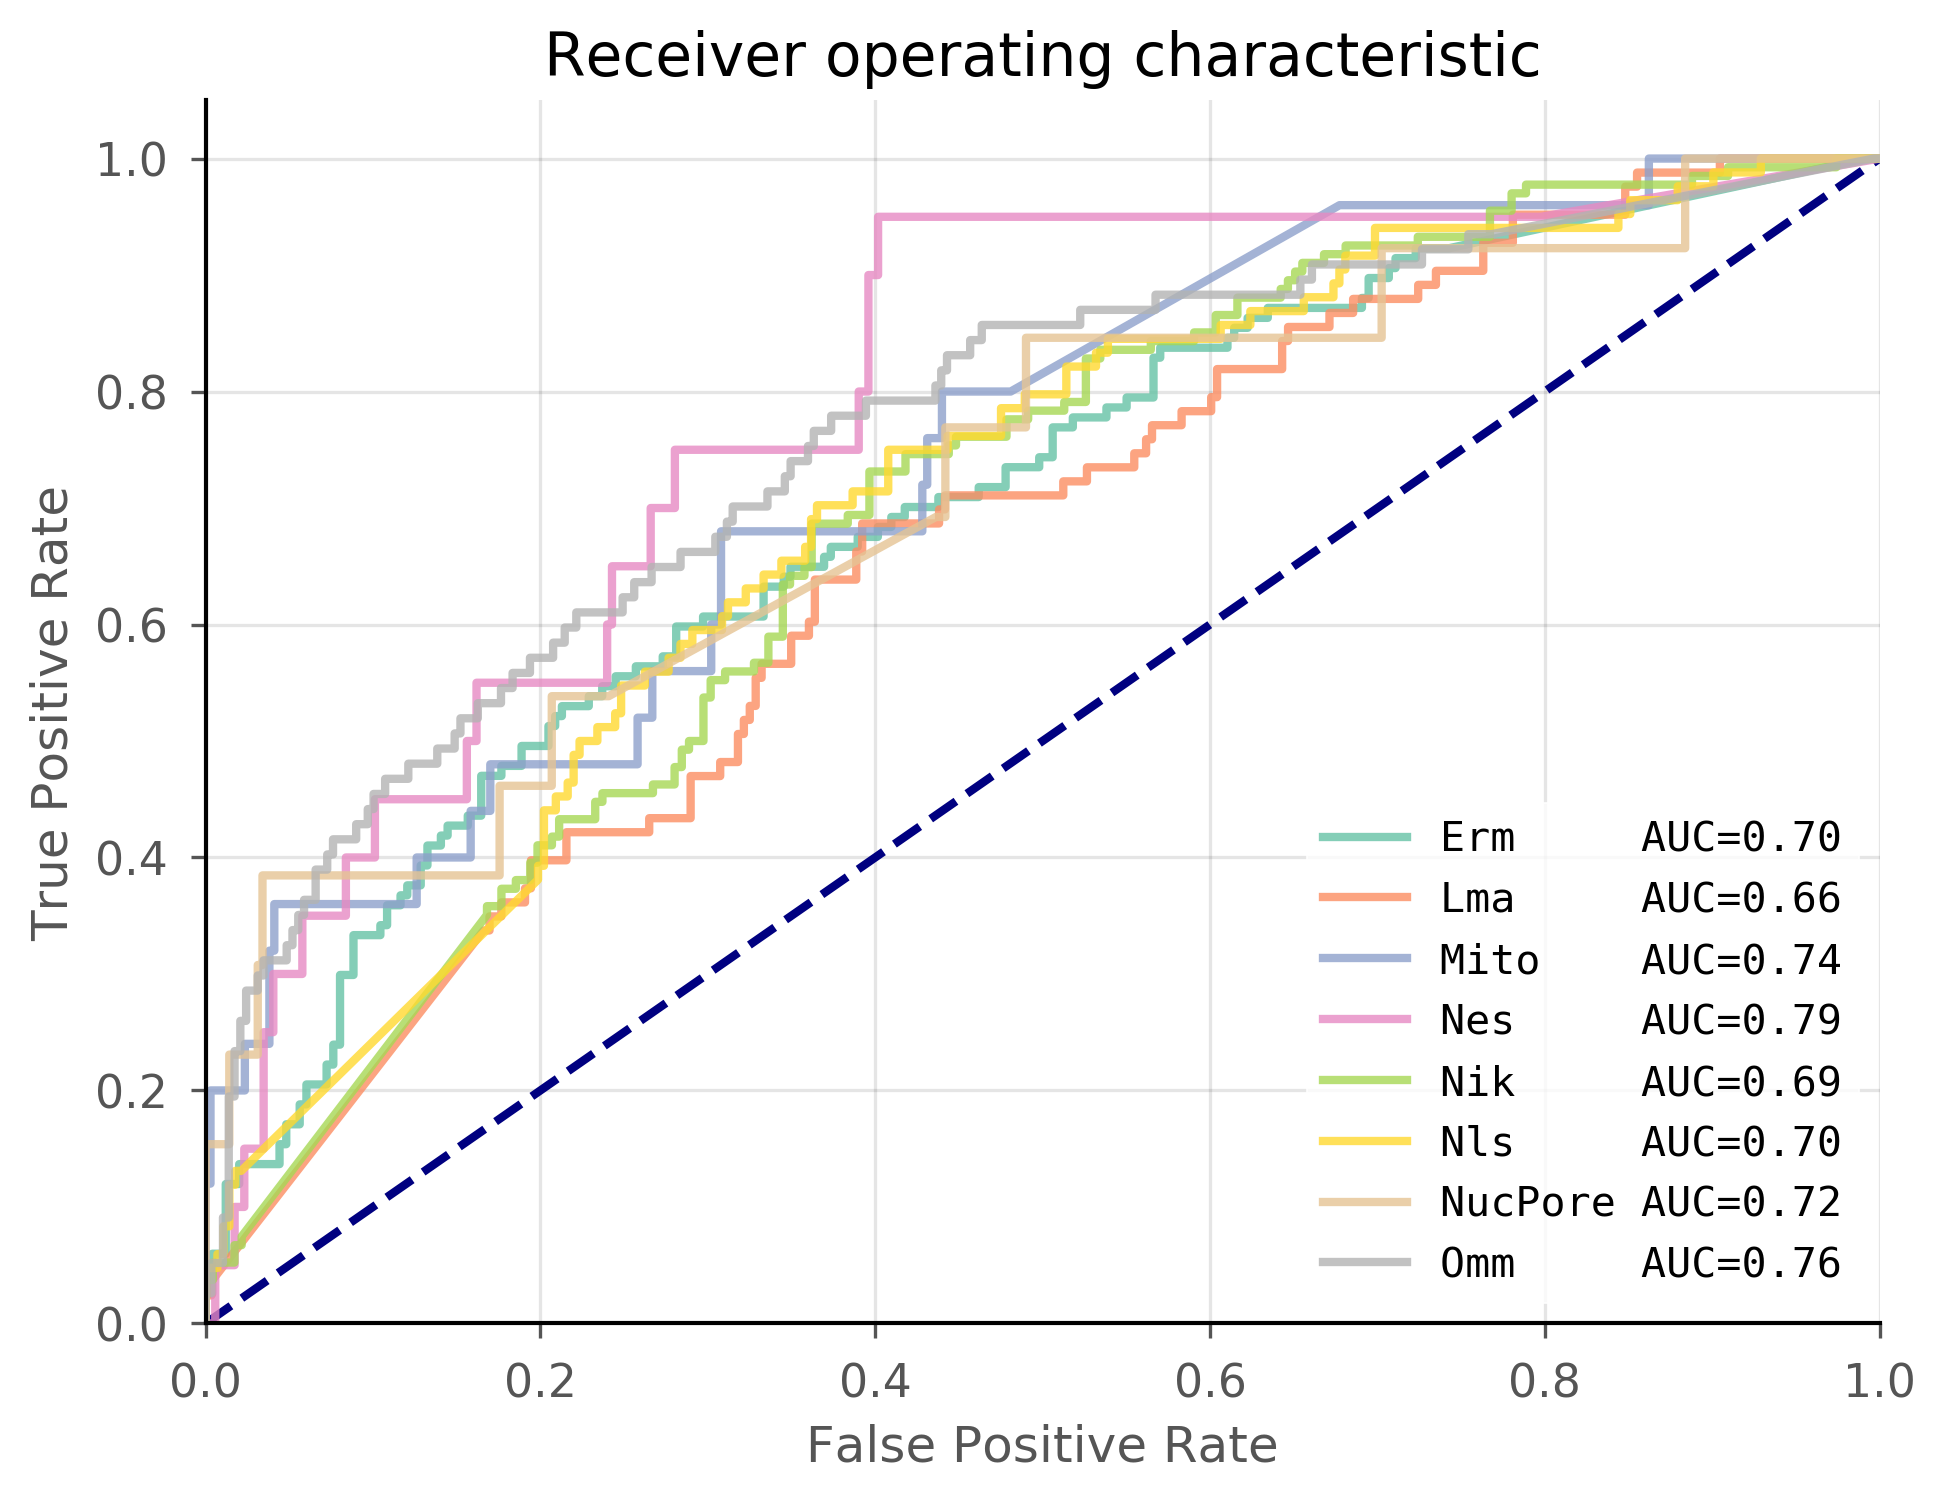

In [16]:
rf_model_no3, rf_per_class_perf_no3, rf_overall_perf_no3 = model_utils.multi_train(
    RandomForestClassifier(**rf_kwargs),
    train_data_no3,
    valid_data_no3,
    verbose=False
)
print("Validation AUROC: {}".format(rf_overall_perf_no3.auroc))
print("Validation AUPRC: {}".format(rf_overall_perf_no3.auprc))
plotting_utils.plot_auroc(
    {localization: perf for localization, perf in zip(train_dataset_no3.compartments, rf_per_class_perf_no3)}
)

In [17]:
rf_per_class_test_perf_no3 = model_utils.generate_multiclass_perf(
    test_data_no3[1],
    rf_model_no3.predict_proba(test_data_no3[0]),
    num_classes=8,
)

## Graphs comparing the above

In [18]:
importlib.reload(seq)
auroc_df = pd.DataFrame(
    0,
    columns=test_dataset.compartments,
    index=['No ablation', "5' UTR", "CDS", "3' UTR"],
)
auprc_df = pd.DataFrame(
    0,
    columns=test_dataset.compartments,
    index=["No ablation", "5' UTR", "CDS", "3' UTR"],
)

for localization, perf in zip(test_dataset.compartments, rf_per_class_test_perf):
    auroc_df.loc['No ablation', localization] = perf.auroc
    auprc_df.loc['No ablation', localization] = perf.auprc

for localization, perf in zip(test_dataset_no5.compartments, rf_per_class_test_perf_no5):
    auroc_df.loc["5' UTR", localization] = perf.auroc
    auprc_df.loc["5' UTR", localization] = perf.auprc

for localization, perf in zip(test_dataset_nocds.compartments, rf_per_class_test_perf_nocds):
    auroc_df.loc['CDS', localization] = perf.auroc
    auprc_df.loc['CDS', localization] = perf.auprc
    
for localization, perf in zip(test_dataset_no3.compartments, rf_per_class_test_perf_no3):
    auroc_df.loc["3' UTR", localization] = perf.auroc
    auprc_df.loc["3' UTR", localization] = perf.auprc

importlib.reload(data_loader)
auroc_df.columns = [data_loader.LOCALIZATION_FULL_NAME_DICT[l] for l in auroc_df.columns]
auprc_df.columns = [data_loader.LOCALIZATION_FULL_NAME_DICT[l] for l in auprc_df.columns]
auroc_df.index = [
    "No ablation",
    "5' UTR",
    "CDS (*)",
    "3' UTR (*)",
]
auprc_df.index = auroc_df.index
print(auroc_df)

             ER membrane  Nuclear lamina  Mito matrix   Cytosol  Nucleolus  \
No ablation     0.781673        0.744951     0.708552  0.861425   0.693970   
5' UTR          0.784993        0.736978     0.713230  0.869118   0.689674   
CDS (*)         0.731233        0.676772     0.663454  0.802149   0.653078   
3' UTR (*)      0.757961        0.685653     0.706774  0.805204   0.679168   

              Nucleus  Nuclear pore  Outer mito membrane  
No ablation  0.755114      0.804652             0.792614  
5' UTR       0.763068      0.822687             0.791892  
CDS (*)      0.713986      0.806000             0.648295  
3' UTR (*)   0.728409      0.775493             0.785052  


In [19]:
for trans_part in auroc_df.index[1:]:
    auroc_t, auroc_p = scipy.stats.ttest_rel(auroc_df.loc['No ablation', :], auroc_df.loc[trans_part, :])
    auprc_t, auprc_p = scipy.stats.ttest_rel(auprc_df.loc['No ablation', :], auprc_df.loc[trans_part, :])
    print(trans_part, auroc_p, auprc_p)

5' UTR 0.2511696872438506 0.2650856353867606
CDS (*) 0.006292779619542899 0.0011480520433736678
3' UTR (*) 0.007667784628603733 0.0026572384018769646


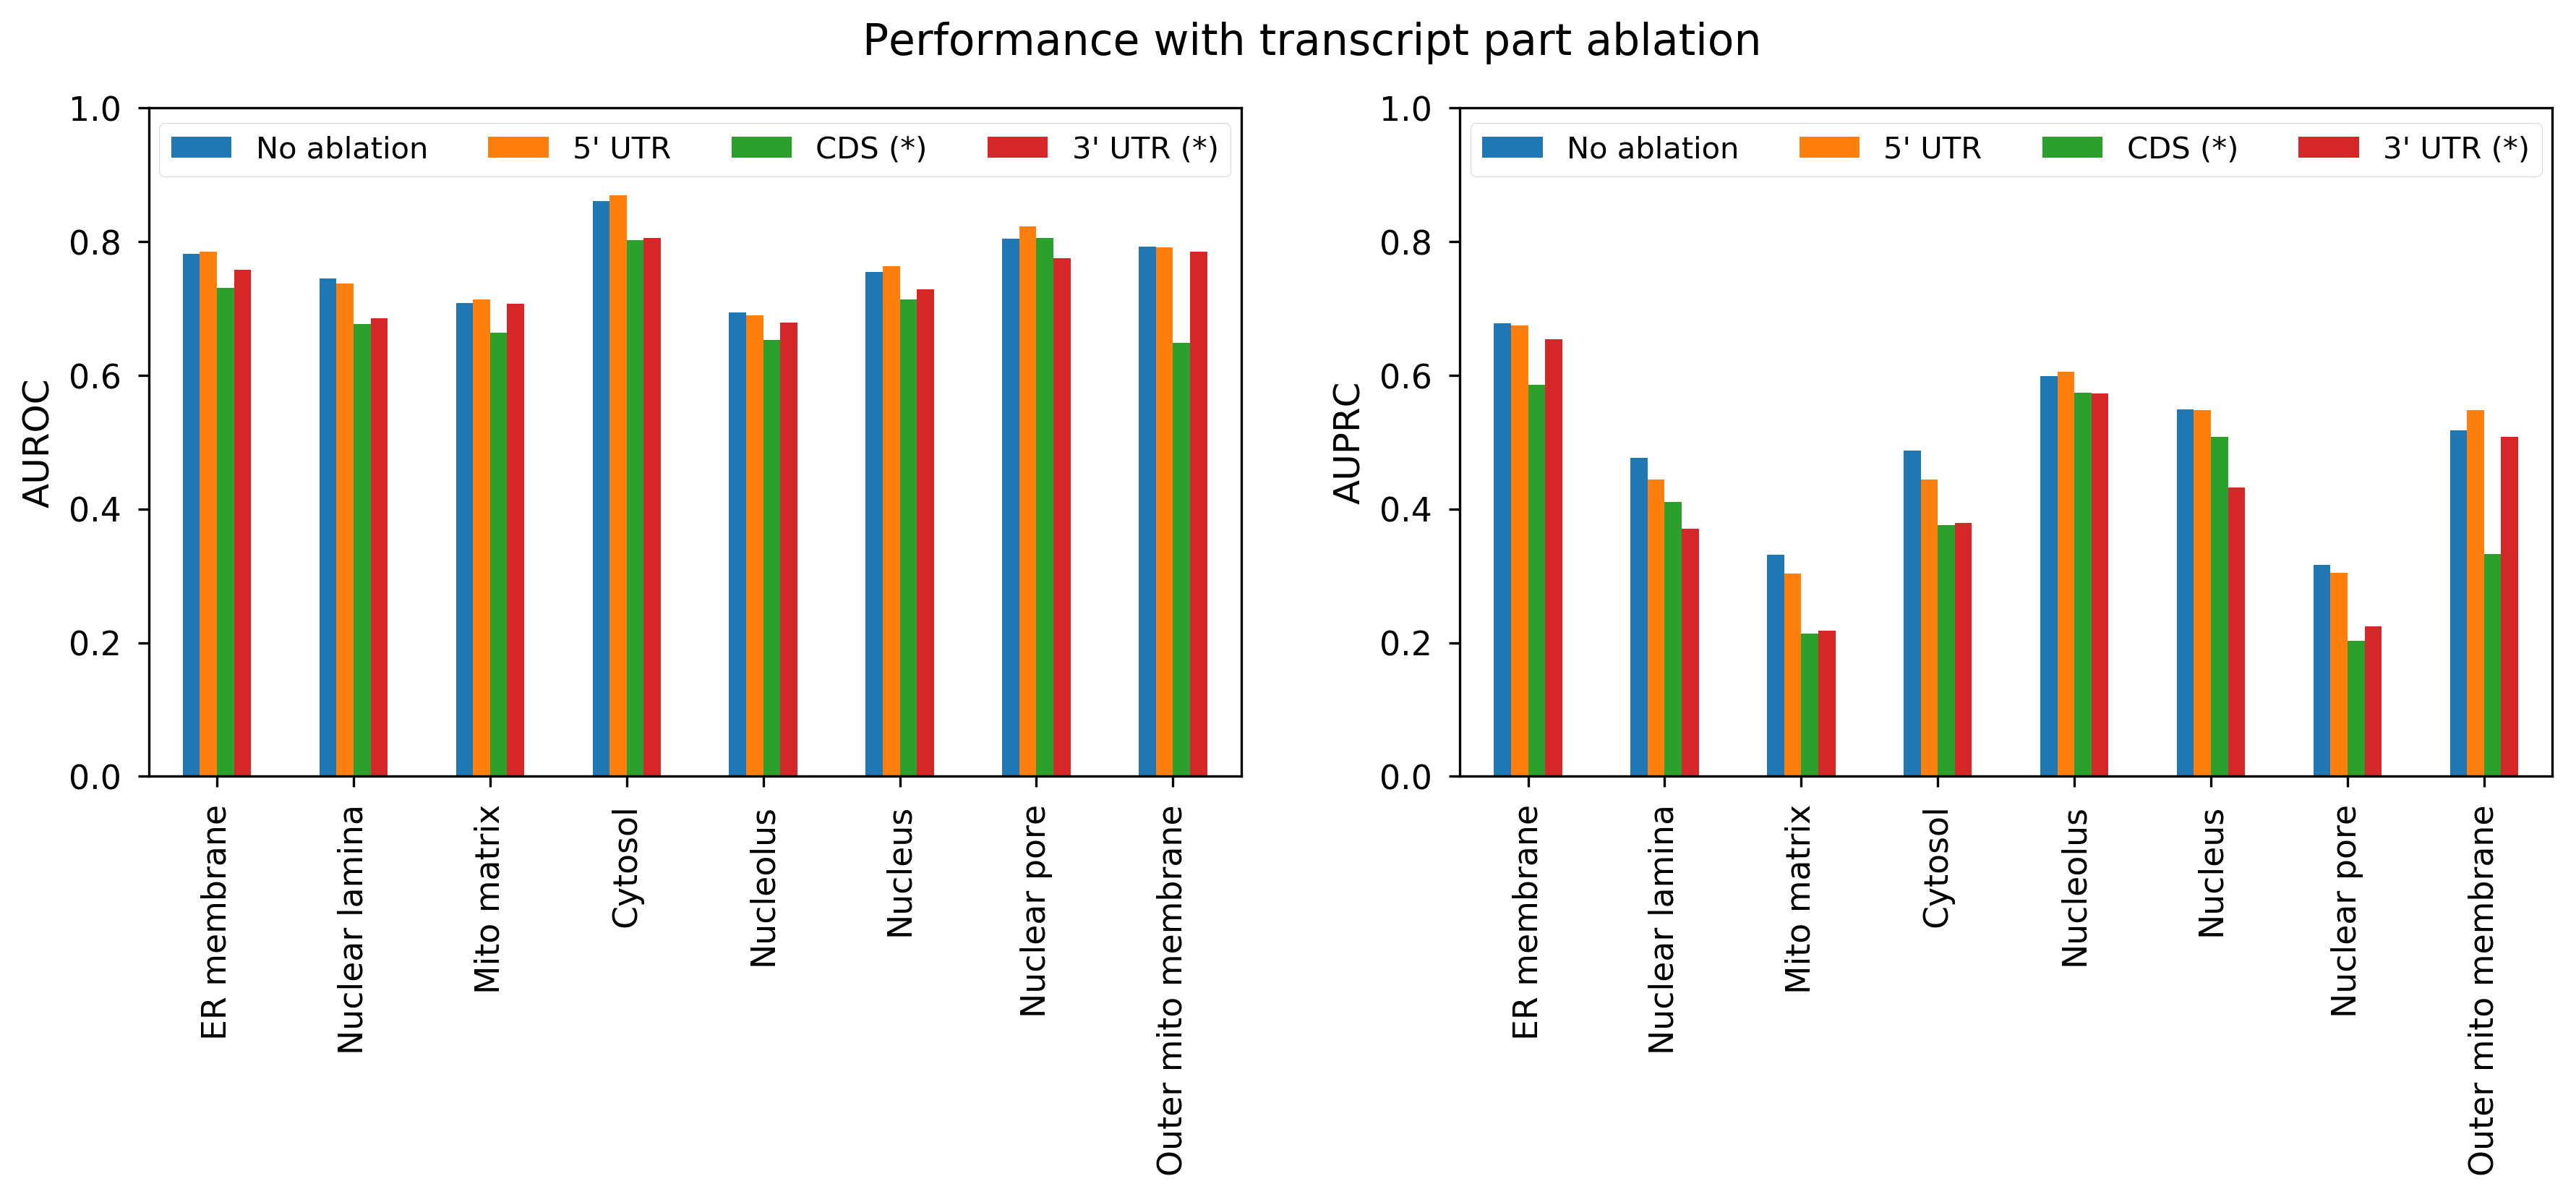

In [70]:
# THIS IS ON TEST SET
fig, (ax1, ax2) = plt.subplots(dpi=300, ncols=2, figsize=(14.3, 4))
auroc_df.T.plot.bar(ax=ax1, legend=True)
ax1.set(
#     title="Transcript part ablation performance",
    ylabel="AUROC",
    ylim=[0, 1],
)
ax1.legend(
    loc='upper center',
    ncol=4,
)

auprc_df.T.plot.bar(ax=ax2, legend=True)
ax2.set(
#     title="Transcript part ablation performance",
    ylabel="AUPRC",
    ylim=[0, 1],
)
ax2.legend(
    loc='upper center',
    ncol=4,
)
fig.suptitle("Performance with transcript part ablation", size='x-large')
fig.savefig(os.path.join(PLOT_DIR, "trans_part_ablation.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

## Different way to evaluate p-value

In [21]:
def list_pred_to_arr(l):
    """Convert list of preds to an array"""
    pos_preds = []
    for p in l:
        assert p.shape[1] == 2
        pos_preds.append(np.atleast_2d(p[:, 1]).T)
    return np.hstack(pos_preds)

valid_preds_orig = list_pred_to_arr(rf_model.predict_proba(valid_data[0]))
valid_preds_5utr = list_pred_to_arr(rf_model_no5.predict_proba(valid_data_no5[0]))
valid_preds_cds = list_pred_to_arr(rf_model_nocds.predict_proba(valid_data_nocds[0]))
valid_preds_3utr = list_pred_to_arr(rf_model_no3.predict_proba(valid_data_no3[0]))

In [22]:
# P-values for overall comparison
print(scipy.stats.ttest_rel(valid_preds_orig.flatten(), valid_preds_5utr.flatten())[1])
print(scipy.stats.ttest_rel(valid_preds_orig.flatten(), valid_preds_cds.flatten())[1])
print(scipy.stats.ttest_rel(valid_preds_orig.flatten(), valid_preds_3utr.flatten())[1])

0.6049857421445464
0.8358803187155728
0.4169765475546864


In [23]:
# P-values for comparing positive localizations
print(np.mean(valid_preds_orig[valid_data[1] > 0]), np.mean(valid_preds_3utr[valid_data[1] > 0]))
print(scipy.stats.ttest_rel(valid_preds_orig[valid_data[1] > 0], valid_preds_5utr[valid_data[1] > 0]))
print(scipy.stats.ttest_rel(valid_preds_orig[valid_data[1] > 0], valid_preds_cds[valid_data[1] > 0]))
print(scipy.stats.ttest_rel(valid_preds_orig[valid_data[1] > 0], valid_preds_3utr[valid_data[1] > 0]))

0.3426461827051791 0.31933179603000855
Ttest_relResult(statistic=0.9840305276212667, pvalue=0.32553160771628664)
Ttest_relResult(statistic=5.7153802729761525, pvalue=1.792776806398825e-08)
Ttest_relResult(statistic=5.843873517975921, pvalue=8.725832457851754e-09)


In [24]:
# P-values for comparing negative localizations
print(np.mean(valid_preds_orig[valid_data[1] == 0]), np.mean(valid_preds_3utr[valid_data[1] == 0]))
print(scipy.stats.ttest_rel(valid_preds_orig[valid_data[1] == 0], valid_preds_5utr[valid_data[1] == 0]))
print(scipy.stats.ttest_rel(valid_preds_orig[valid_data[1] == 0], valid_preds_cds[valid_data[1] == 0]))
print(scipy.stats.ttest_rel(valid_preds_orig[valid_data[1] == 0], valid_preds_3utr[valid_data[1] == 0]))

0.1577741962724811 0.16200904887330916
Ttest_relResult(statistic=-0.017645713011249627, pvalue=0.9859229714372725)
Ttest_relResult(statistic=-3.9080252502847355, pvalue=9.565731793257448e-05)
Ttest_relResult(statistic=-3.802459893043335, pvalue=0.00014687787428727643)


In [25]:
# P-values for comparing each localization, but neg/pos together
print(scipy.stats.ttest_rel(valid_preds_orig, valid_preds_5utr)[1])
print(scipy.stats.ttest_rel(valid_preds_orig, valid_preds_cds)[1])
print(scipy.stats.ttest_rel(valid_preds_orig, valid_preds_3utr)[1])

[0.95628502 0.44310054 0.59779376 0.4381515  0.19308082 0.38648664
 0.7082595  0.621167  ]
[0.88251452 0.89125595 0.78961329 0.13680765 0.77079988 0.95687274
 0.20490891 0.76629064]
[0.89797319 0.27056518 0.24770918 0.96321548 0.07718332 0.81718542
 0.73662004 0.96588387]


In [26]:
# P-values for comparing each localization, but neg/pos separately
def compartmentwise_compare_pos_neg(x, y, truth):
    """Given x and y, both output predictions, compare at each compartment"""
    assert x.shape == y.shape == truth.shape
    assert tuple(sorted(np.unique(truth))) == (0, 1)  # Binary labels
    p_values = []
    for i in range(x.shape[1]):  # Iterate over columns
        x_i, y_i, truth_i = x[:, i], y[:, i], truth[:, i]
        pos_p = scipy.stats.ttest_rel(x_i[truth_i > 0], y_i[truth_i > 0])[1]
        neg_p = scipy.stats.ttest_rel(x_i[truth_i == 0], y_i[truth_i == 0])[1]
        p_values.append(np.array([neg_p, pos_p]))
    return np.vstack(p_values)

pred_p_5utr = compartmentwise_compare_pos_neg(valid_preds_orig, valid_preds_5utr, valid_data[1])
pred_p_cds = compartmentwise_compare_pos_neg(valid_preds_orig, valid_preds_cds, valid_data[1])
pred_p_3utr = compartmentwise_compare_pos_neg(valid_preds_orig, valid_preds_3utr, valid_data[1])

In [27]:
pred_p_5utr

array([[0.36162106, 0.27226088],
       [0.73318248, 0.33477692],
       [0.97490938, 0.17970883],
       [0.7618618 , 0.14822898],
       [0.43091194, 0.26777603],
       [0.42547646, 0.72413298],
       [0.72636318, 0.86990528],
       [0.57696798, 0.95480882]])

In [28]:
pred_p_cds

array([[7.14622588e-02, 2.77914217e-02],
       [6.96893376e-01, 4.63921501e-01],
       [1.98247626e-01, 1.27860639e-02],
       [6.83188384e-02, 4.05948937e-01],
       [1.48086419e-02, 5.27888017e-04],
       [2.26664026e-01, 1.13823133e-01],
       [5.10282775e-01, 1.51335387e-02],
       [6.56247639e-02, 5.37084491e-04]])

In [29]:
pred_p_3utr

array([[2.80706516e-03, 3.24193082e-04],
       [4.19317055e-01, 1.15510550e-02],
       [8.64734906e-03, 1.66017487e-01],
       [9.67679506e-01, 9.73400400e-01],
       [8.55304093e-01, 1.75817480e-02],
       [6.68682283e-03, 1.83242062e-03],
       [7.23878590e-01, 9.90944388e-01],
       [8.76864146e-01, 7.24031672e-01]])

In [30]:
pred_p_combined = pd.DataFrame(
    np.hstack((
        pred_p_5utr[:, ::-1],
        pred_p_cds[:, ::-1],
        pred_p_3utr[:, ::-1],
    )),
    index=[data_loader.LOCALIZATION_FULL_NAME_DICT[c] for c in valid_dataset.compartments],
    columns=pd.MultiIndex.from_product(
        (["5' UTR", "CDS", "3' UTR"],
        ["p+", "p-"]),
        names=["Ablated segment", "pos_neg"]
    )
)
pred_p_combined

Ablated segment        5' UTR                 CDS              3' UTR  \
pos_neg                    p+        p-        p+        p-        p+   
ER membrane          0.272261  0.361621  0.027791  0.071462  0.000324   
Nuclear lamina       0.334777  0.733182  0.463922  0.696893  0.011551   
Mito matrix          0.179709  0.974909  0.012786  0.198248  0.166017   
Cytosol              0.148229  0.761862  0.405949  0.068319  0.973400   
Nucleolus            0.267776  0.430912  0.000528  0.014809  0.017582   
Nucleus              0.724133  0.425476  0.113823  0.226664  0.001832   
Nuclear pore         0.869905  0.726363  0.015134  0.510283  0.990944   
Outer mito membrane  0.954809  0.576968  0.000537  0.065625  0.724032   

Ablated segment                
pos_neg                    p-  
ER membrane          0.002807  
Nuclear lamina       0.419317  
Mito matrix          0.008647  
Cytosol              0.967680  
Nucleolus            0.855304  
Nucleus              0.006687  
Nuclear pore         0.723879  
Outer mito membrane  0.876864

In [31]:
pred_p_combined_neg_log = -np.log(pred_p_combined)
pred_p_combined_neg_log

Ablated segment        5' UTR                 CDS              3' UTR  \
pos_neg                    p+        p-        p+        p-        p+   
ER membrane          1.300995  1.017158  3.583028  2.638586  8.034171   
Nuclear lamina       1.094291  0.310361  0.768040  0.361123  4.460978   
Mito matrix          1.716417  0.025411  4.359399  1.618238  1.795662   
Cytosol              1.908997  0.271990  0.901528  2.683570  0.026960   
Nucleolus            1.317604  0.841852  7.546626  4.212544  4.040894   
Nucleus              0.322780  0.854546  2.173109  1.484286  6.302117   
Nuclear pore         0.139371  0.319705  4.190842  0.672790  0.009097   
Outer mito membrane  0.046244  0.549969  7.529355  2.723802  0.322920   

Ablated segment                
pos_neg                    p-  
ER membrane          5.875616  
Nuclear lamina       0.869128  
Mito matrix          4.750502  
Cytosol              0.032854  
Nucleolus            0.156298  
Nucleus              5.007616  
Nuclear pore         0.323132  
Outer mito membrane  0.131403

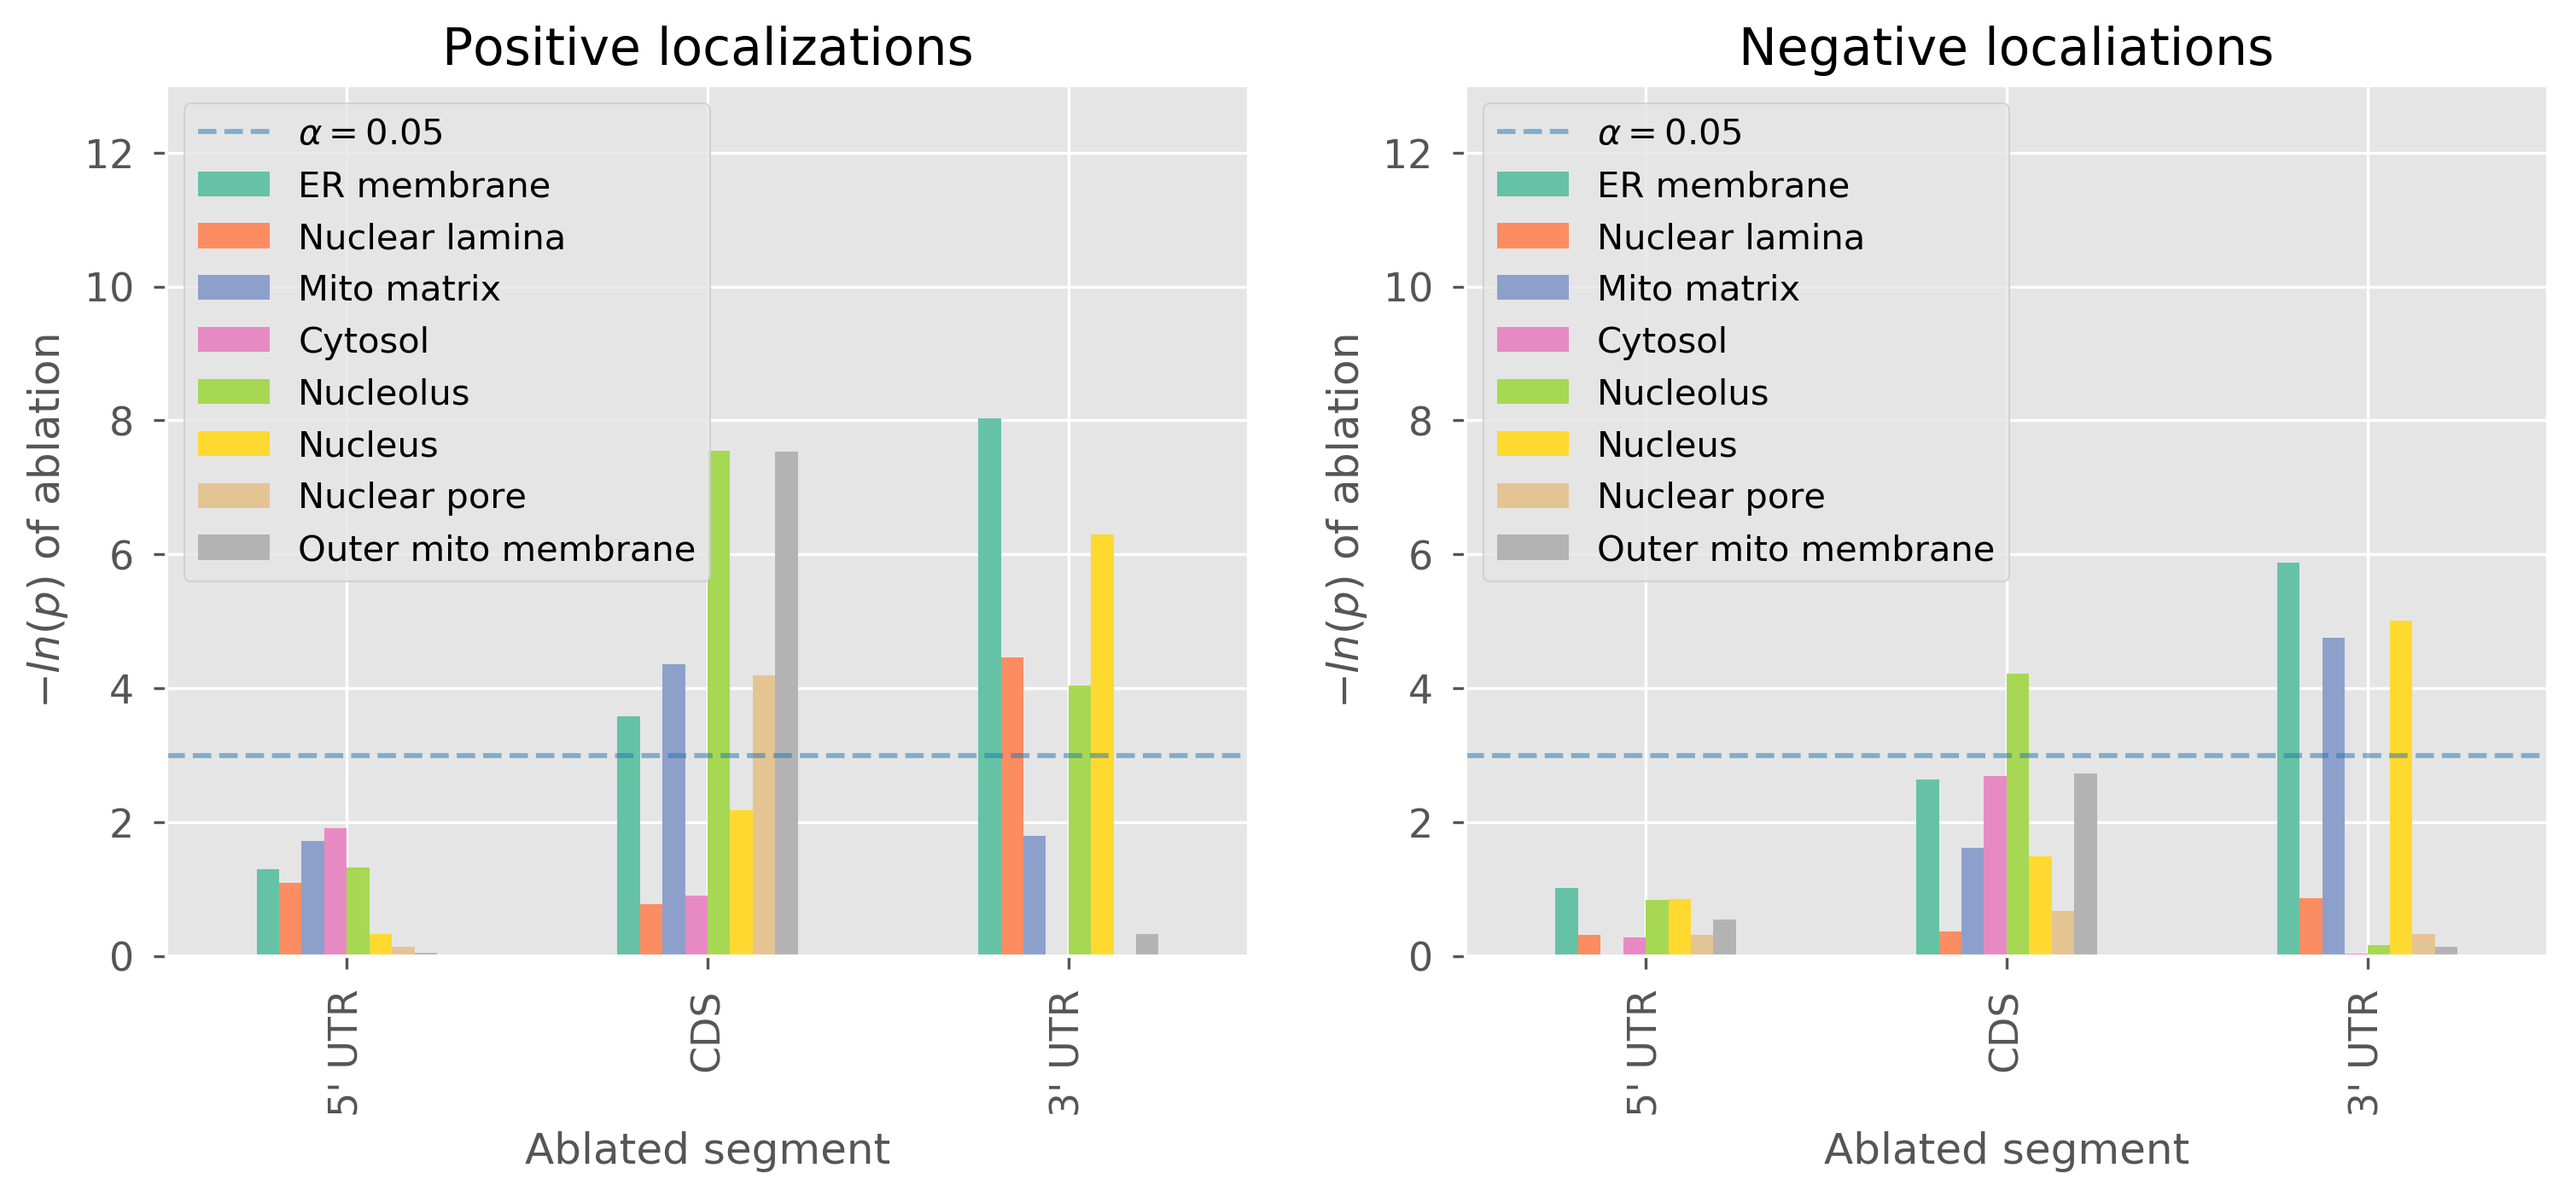

In [32]:
from matplotlib import cm

fig, (ax1, ax2) = plt.subplots(dpi=300, ncols=2, figsize=(12, 4.5))
pred_p_combined_neg_log.xs("p+", level='pos_neg', axis=1, drop_level=True).T.plot.bar(ax=ax1, cmap=cm.get_cmap('Set2'))
ax1.axhline(-np.log(0.05), linestyle='--', alpha=0.5, label=r"$\alpha=0.05$", color='tab:blue')
ax1.legend()
ax1.set(
    ylabel=r"$-ln(p)$ of ablation",
    title="Positive localizations",
    ylim=(0, 13),
)
pred_p_combined_neg_log.xs("p-", level='pos_neg', axis=1, drop_level=True).T.plot.bar(ax=ax2, cmap=cm.get_cmap('Set2'))
ax2.axhline(-np.log(0.05), linestyle='--', alpha=0.5, label=r"$\alpha=0.05$", color='tab:blue')
ax2.legend()
ax2.set(
    ylabel=r"$-ln(p)$ of ablation",
    title="Negative localiations",
    ylim=(0, 13),
)
# fig.suptitle("Impact of segment ablation on positive and negative localizations", size=18)
fig.show()

In [33]:
np.all(pred_p_5utr < 0.05, axis=1)

array([False, False, False, False, False, False, False, False])

In [34]:
np.all(pred_p_cds < 0.05, axis=1)

array([False, False, False, False,  True, False, False, False])

In [35]:
np.all(pred_p_3utr < 0.05, axis=1)

array([ True, False, False, False, False,  True, False, False])

In [36]:
pred_p_5utr[:, 1] < 0.05

array([False, False, False, False, False, False, False, False])

In [37]:
pred_p_cds[:, 1] < 0.05

array([ True, False,  True, False,  True, False,  True,  True])

In [38]:
pred_p_3utr[:, 1] < 0.05

array([ True,  True, False, False,  True,  True, False, False])

## Same as above, but for test set

In [39]:
test_preds_orig = list_pred_to_arr(rf_model.predict_proba(test_data[0]))
test_preds_5utr = list_pred_to_arr(rf_model_no5.predict_proba(test_data_no5[0]))
test_preds_cds = list_pred_to_arr(rf_model_nocds.predict_proba(test_data_nocds[0]))
test_preds_3utr = list_pred_to_arr(rf_model_no3.predict_proba(test_data_no3[0]))

In [40]:
# P-values for overall comparison
print(scipy.stats.ttest_rel(test_preds_orig.flatten(), test_preds_5utr.flatten())[1])
print(scipy.stats.ttest_rel(test_preds_orig.flatten(), test_preds_cds.flatten())[1])
print(scipy.stats.ttest_rel(test_preds_orig.flatten(), test_preds_3utr.flatten())[1])

0.8377313623714998
0.6781771980692697
0.851358821724352


In [41]:
# P-values for comparing positive localizations
print(np.mean(test_preds_orig[test_data[1] > 0]), np.mean(test_preds_3utr[test_data[1] > 0]))
print(scipy.stats.ttest_rel(test_preds_orig[test_data[1] > 0], test_preds_5utr[test_data[1] > 0]))
print(scipy.stats.ttest_rel(test_preds_orig[test_data[1] > 0], test_preds_cds[test_data[1] > 0]))
print(scipy.stats.ttest_rel(test_preds_orig[test_data[1] > 0], test_preds_3utr[test_data[1] > 0]))

0.34554819938985853 0.328426136704746
Ttest_relResult(statistic=-0.5909222687861768, pvalue=0.5548075651819611)
Ttest_relResult(statistic=7.2860083950842345, pvalue=1.0732676440145023e-12)
Ttest_relResult(statistic=5.13661995394484, pvalue=3.8506323727828073e-07)


In [42]:
# P-values for comparing negative localizations
print(np.mean(test_preds_orig[test_data[1] == 0]), np.mean(test_preds_3utr[test_data[1] == 0]))
print(scipy.stats.ttest_rel(test_preds_orig[test_data[1] == 0], test_preds_5utr[test_data[1] == 0]))
print(scipy.stats.ttest_rel(test_preds_orig[test_data[1] == 0], test_preds_cds[test_data[1] == 0]))
print(scipy.stats.ttest_rel(test_preds_orig[test_data[1] == 0], test_preds_3utr[test_data[1] == 0]))

0.15631298198838492 0.1602007049380003
Ttest_relResult(statistic=0.12381864811988082, pvalue=0.9014694194114238)
Ttest_relResult(statistic=-5.2934725777033504, pvalue=1.3110973582033696e-07)
Ttest_relResult(statistic=-3.910643204596984, pvalue=9.465062629998842e-05)


In [43]:
# P-values for comparing each localization, but neg/pos together
print(scipy.stats.ttest_rel(test_preds_orig, test_preds_5utr)[1])
print(scipy.stats.ttest_rel(test_preds_orig, test_preds_cds)[1])
print(scipy.stats.ttest_rel(test_preds_orig, test_preds_3utr)[1])

[0.14051042 0.72868935 0.69874215 0.84864022 0.21378632 0.98490024
 0.8150143  0.88568519]
[0.28037188 0.30594445 0.08350516 0.10603081 0.3182956  0.08271643
 0.38851618 0.57556749]
[0.94609711 0.80010737 0.6800111  0.8574479  0.81081815 0.91782314
 0.4261569  0.78920325]


In [44]:
test_pred_p_5utr = compartmentwise_compare_pos_neg(test_preds_orig, test_preds_5utr, test_data[1])
test_pred_p_cds = compartmentwise_compare_pos_neg(test_preds_orig, test_preds_cds, test_data[1])
test_pred_p_3utr = compartmentwise_compare_pos_neg(test_preds_orig, test_preds_3utr, test_data[1])

In [45]:
test_pred_p_5utr

array([[0.44000946, 0.14665927],
       [0.45522566, 0.48132147],
       [0.67264823, 0.97744023],
       [0.89511347, 0.85104945],
       [0.34811131, 0.41676912],
       [0.64913387, 0.33631886],
       [0.69425378, 0.58406907],
       [0.63756365, 0.28573013]])

In [46]:
test_pred_p_cds

array([[1.10527239e-01, 1.78418903e-04],
       [5.50864052e-02, 2.39057460e-01],
       [1.64154269e-02, 6.86956454e-02],
       [4.29949078e-01, 3.21532882e-02],
       [1.60093780e-01, 5.84240247e-04],
       [4.81511253e-03, 2.44842003e-01],
       [8.15814934e-01, 6.08413758e-02],
       [2.00360817e-04, 1.34130771e-06]])

In [47]:
test_pred_p_3utr

array([[0.03461464, 0.00251614],
       [0.05727662, 0.00805039],
       [0.05173389, 0.07691811],
       [0.36633792, 0.17894753],
       [0.21755835, 0.22531151],
       [0.04495139, 0.00683477],
       [0.9819204 , 0.03090632],
       [0.93021317, 0.49003628]])

In [48]:
test_pred_p_combined = pd.DataFrame(
    np.hstack((
        test_pred_p_5utr[:, ::-1],
        test_pred_p_cds[:, ::-1],
        test_pred_p_3utr[:, ::-1],
    )),
    index=[data_loader.LOCALIZATION_FULL_NAME_DICT[c] for c in test_dataset.compartments],
    columns=pd.MultiIndex.from_product(
        (["5' UTR", "CDS", "3' UTR"],
        ["p+", "p-"]),
        names=["Ablated segment", "pos_neg"]
    )
)
test_pred_p_combined

Ablated segment        5' UTR                 CDS              3' UTR  \
pos_neg                    p+        p-        p+        p-        p+   
ER membrane          0.146659  0.440009  0.000178  0.110527  0.002516   
Nuclear lamina       0.481321  0.455226  0.239057  0.055086  0.008050   
Mito matrix          0.977440  0.672648  0.068696  0.016415  0.076918   
Cytosol              0.851049  0.895113  0.032153  0.429949  0.178948   
Nucleolus            0.416769  0.348111  0.000584  0.160094  0.225312   
Nucleus              0.336319  0.649134  0.244842  0.004815  0.006835   
Nuclear pore         0.584069  0.694254  0.060841  0.815815  0.030906   
Outer mito membrane  0.285730  0.637564  0.000001  0.000200  0.490036   

Ablated segment                
pos_neg                    p-  
ER membrane          0.034615  
Nuclear lamina       0.057277  
Mito matrix          0.051734  
Cytosol              0.366338  
Nucleolus            0.217558  
Nucleus              0.044951  
Nuclear pore         0.981920  
Outer mito membrane  0.930213

In [49]:
test_pred_p_combined_neg_log = -np.log(test_pred_p_combined)
test_pred_p_combined_neg_log

Ablated segment        5' UTR                  CDS              3' UTR  \
pos_neg                    p+        p-         p+        p-        p+   
ER membrane          1.919643  0.820959   8.631376  2.202493  5.985030   
Nuclear lamina       0.731220  0.786962   1.431051  2.898852  4.822035   
Mito matrix          0.022818  0.396533   2.678069  4.109534  2.565014   
Cytosol              0.161285  0.110805   3.437241  0.844089  1.720663   
Nucleolus            0.875223  1.055233   7.445198  1.831996  1.490271   
Nucleus              1.089696  0.432116   1.407142  5.335996  4.985732   
Nuclear pore         0.537736  0.364918   2.799485  0.203568  3.476794   
Outer mito membrane  1.252708  0.450101  13.521866  8.515391  0.713276   

Ablated segment                
pos_neg                    p-  
ER membrane          3.363479  
Nuclear lamina       2.859863  
Mito matrix          2.961642  
Cytosol              1.004199  
Nucleolus            1.525288  
Nucleus              3.102174  
Nuclear pore         0.018245  
Outer mito membrane  0.072342

In [50]:
def df_to_latek(df, prettymath=False):
    """Convert numeric values to df"""
    latek_rows = []
    for row in df.iterrows():
        latek_row = [row[0]]
        for val in row[1]:
            str_val = "{:.2e}".format(val) if val < 0.1 else "{:.2f}".format(val)
            if prettymath:
                if "e-" in str_val: str_val += "}"
                str_val = str_val.replace(r"e-", r"\times 10^{-")
                str_val = "$" + str_val + "$"
            if val < 0.05:
                x = "textbf{" + str_val + "}"
                s = r"\ ".strip() + x
            else:
                s = str_val
            latek_row.append(s)
        latek_row_str = ' & '.join(latek_row) + r" \\"
        latek_rows.append(latek_row_str)
    retval = "\n".join(latek_rows)
    return retval

print(df_to_latek(test_pred_p_combined))

ER membrane & 0.15 & 0.44 & \textbf{1.78e-04} & 0.11 & \textbf{2.52e-03} & \textbf{3.46e-02} \\
Nuclear lamina & 0.48 & 0.46 & 0.24 & 5.51e-02 & \textbf{8.05e-03} & 5.73e-02 \\
Mito matrix & 0.98 & 0.67 & 6.87e-02 & \textbf{1.64e-02} & 7.69e-02 & 5.17e-02 \\
Cytosol & 0.85 & 0.90 & \textbf{3.22e-02} & 0.43 & 0.18 & 0.37 \\
Nucleolus & 0.42 & 0.35 & \textbf{5.84e-04} & 0.16 & 0.23 & 0.22 \\
Nucleus & 0.34 & 0.65 & 0.24 & \textbf{4.82e-03} & \textbf{6.83e-03} & \textbf{4.50e-02} \\
Nuclear pore & 0.58 & 0.69 & 6.08e-02 & 0.82 & \textbf{3.09e-02} & 0.98 \\
Outer mito membrane & 0.29 & 0.64 & \textbf{1.34e-06} & \textbf{2.00e-04} & 0.49 & 0.93 \\


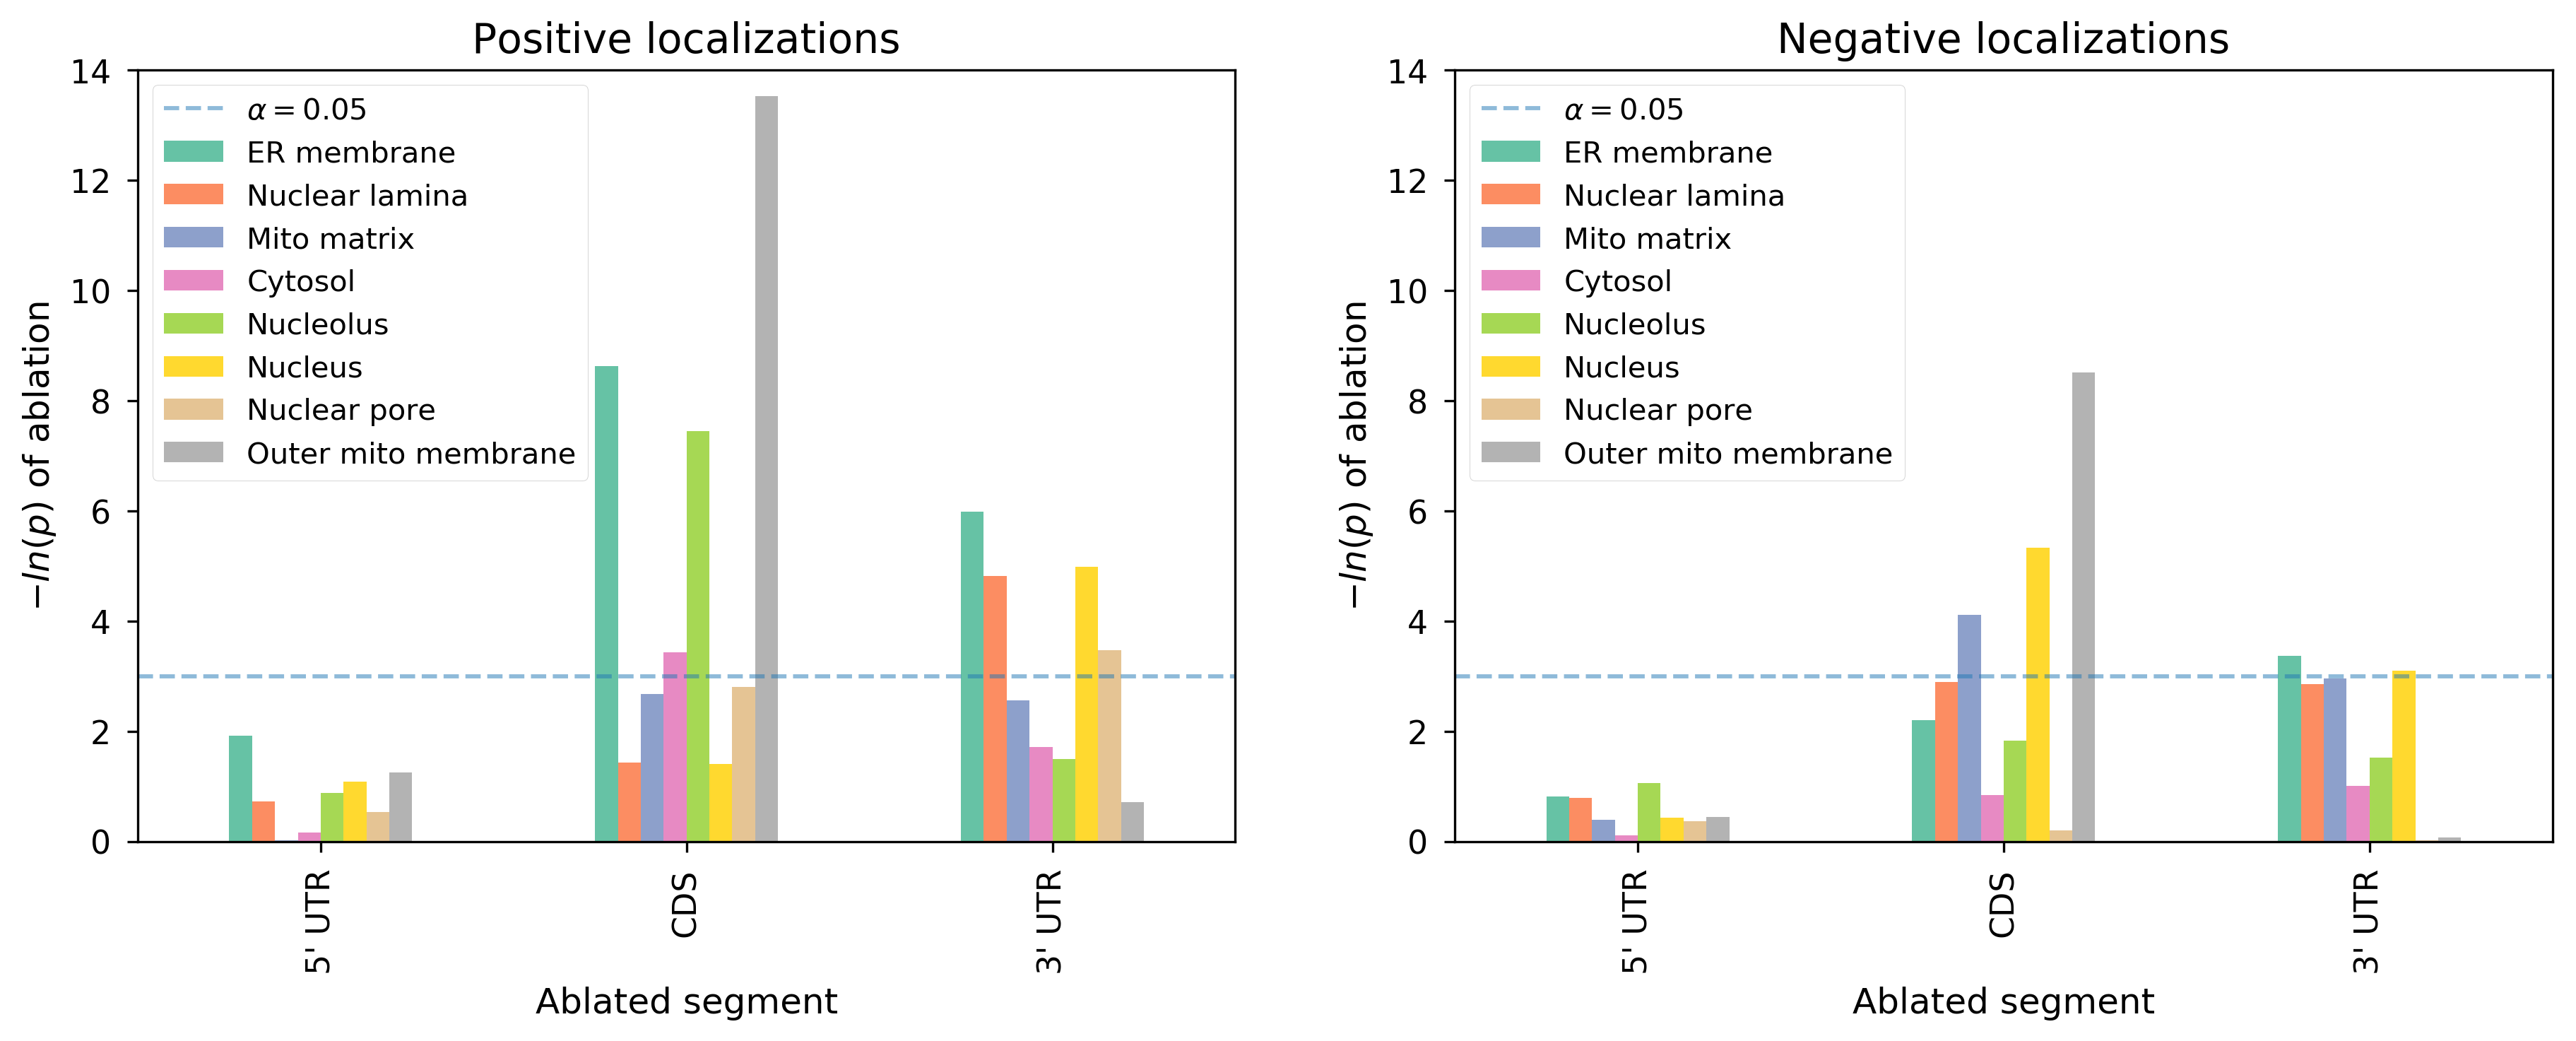

In [61]:
# TEST SET
fig, (ax1, ax2) = plt.subplots(dpi=300, ncols=2, figsize=(14*1.05, 4.5*1.05))
test_pred_p_combined_neg_log.xs("p+", level='pos_neg', axis=1, drop_level=True).T.plot.bar(ax=ax1, cmap=cm.get_cmap('Set2'))
ax1.axhline(-np.log(0.05), linestyle='--', alpha=0.5, label=r"$\alpha=0.05$", color='tab:blue')
ax1.legend(loc='upper left')
ax1.set(
    ylabel=r"$-ln(p)$ of ablation",
    title="Positive localizations",
    ylim=(0, 14),
)

test_pred_p_combined_neg_log.xs("p-", level='pos_neg', axis=1, drop_level=True).T.plot.bar(ax=ax2, cmap=cm.get_cmap('Set2'))
ax2.axhline(-np.log(0.05), linestyle='--', alpha=0.5, label=r"$\alpha=0.05$", color='tab:blue')
ax2.legend(loc='upper left')
ax2.set(
    ylabel=r"$-ln(p)$ of ablation",
    title="Negative localizations",
    ylim=(0, 14),
)
# fig.suptitle("Impact of segment ablation on positive and negative localizations", size=18)
fig.savefig(os.path.join(PLOT_DIR, "trans_part_ablation_p_bar.pdf"), dpi=1200, bbox_inches='tight')
fig.show()

In [52]:
np.all(test_pred_p_5utr < 0.05, axis=1)

array([False, False, False, False, False, False, False, False])

In [53]:
np.all(test_pred_p_cds < 0.05, axis=1)

array([False, False, False, False, False, False, False,  True])

In [54]:
np.all(test_pred_p_3utr < 0.05, axis=1)

array([ True, False, False, False, False,  True, False, False])

In [55]:
test_pred_p_5utr[:, 1] < 0.05

array([False, False, False, False, False, False, False, False])

In [56]:
test_pred_p_cds[:, 1] < 0.05

array([ True, False, False,  True,  True, False, False,  True])

In [57]:
test_pred_p_3utr[:, 1] < 0.05

array([ True,  True, False, False, False,  True,  True, False])

## Remake bar plot with asterisks

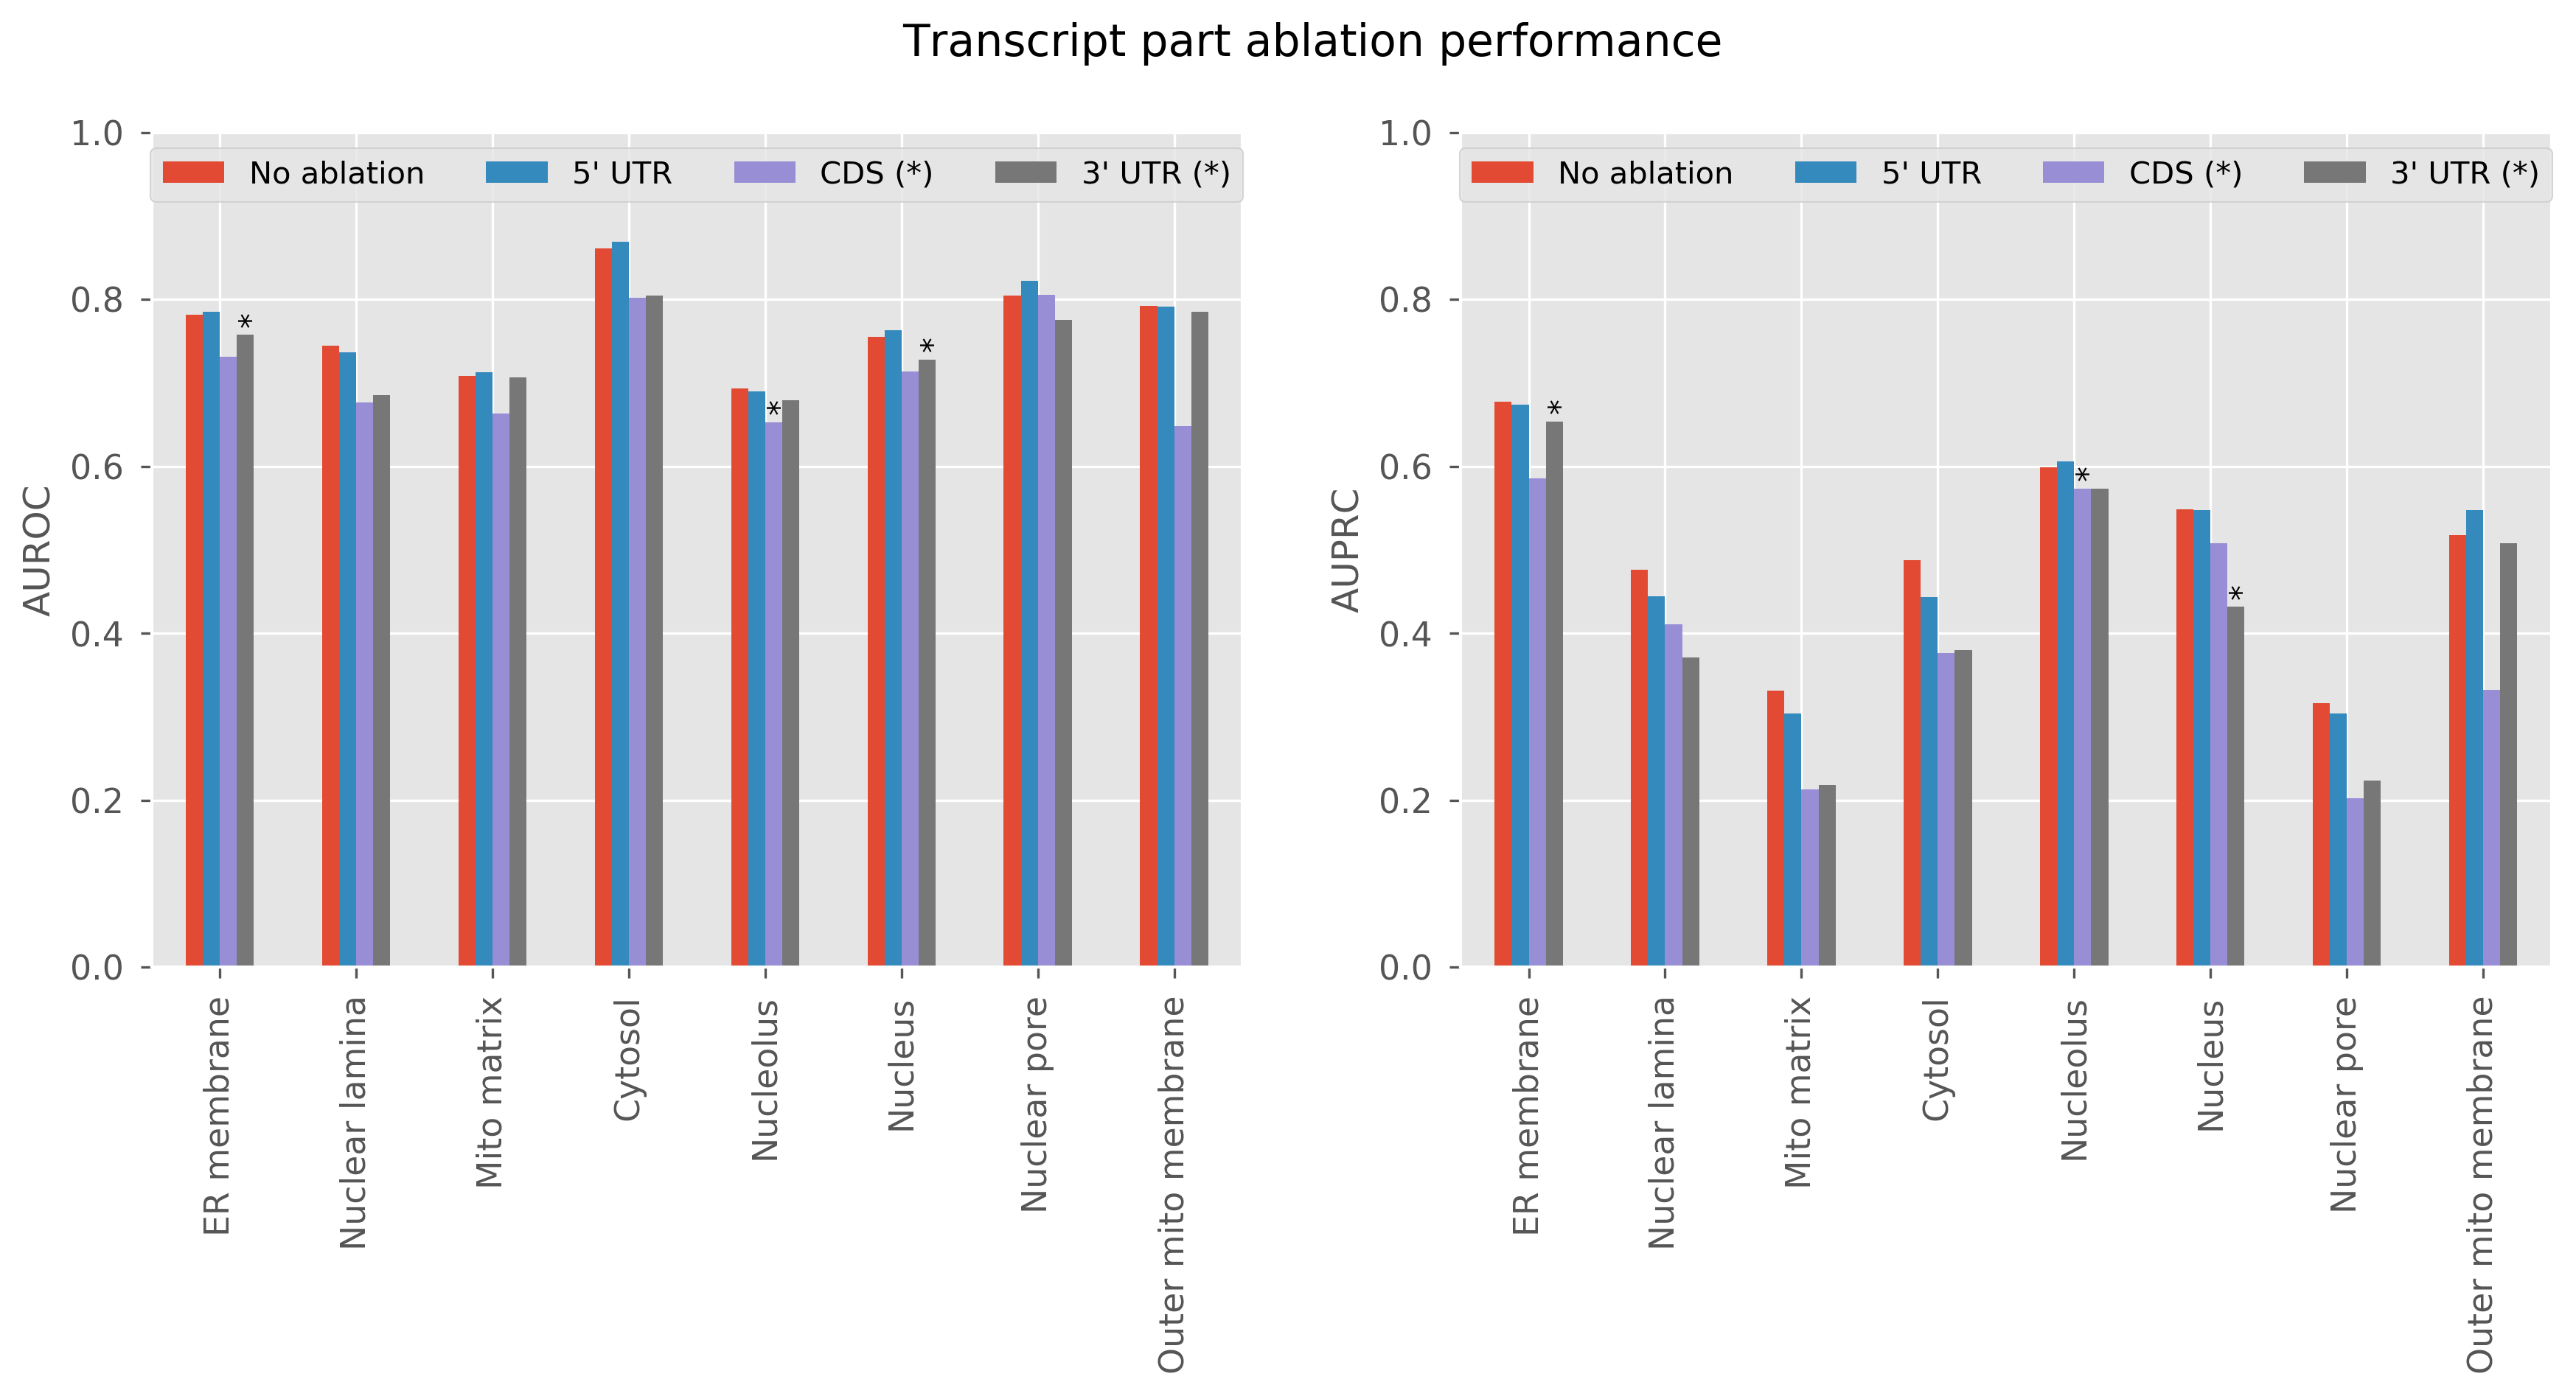

In [58]:
def annotate_ablation_barplot(ax, p_values=[pred_p_5utr, pred_p_cds, pred_p_3utr]):
    for i, p in enumerate(ax.patches):  # Iterates over comparmtnets, then over ablations
        # https://github.com/mwaskom/seaborn/issues/1582
        compartment_index = i % 8    
        ablation_index = i // 8  # Indexes into [5', cds, 3']
        assert ablation_index < 4 and compartment_index < 8
        if ablation_index == 0:
            continue  # Skip no ablation case
        p_vals = p_values[ablation_index - 1][compartment_index]
        if any(p_vals > 0.05):
            continue  # Do not annotate if either pos or negative is not significant
        ax.annotate(
    #         f"{format(p_vals[1], '.2f')} | {format(p_vals[0], '.2f')}",
            "*",
    #         (p.get_x() + p.get_width() / 2, p.get_height()),
            (p.get_x() + p.get_width() * 0.94, p.get_height()),
            ha='center',
            va='center',
            xytext=(0, 5),
            textcoords='offset points',
            rotation=90,
        )

fig, (ax1, ax2) = plt.subplots(dpi=300, ncols=2, figsize=(14, 5))
auroc_df.T.plot.bar(ax=ax1, legend=True)
ax1.set(
    ylabel="AUROC",
#     facecolor='white',
    ylim=[0, 1],
)
annotate_ablation_barplot(ax1)
ax1.legend(
    loc='upper center',
    ncol=4,
)

auprc_df.T.plot.bar(ax=ax2, legend=True)
ax2.set(
    ylabel="AUPRC",
#     facecolor='white',
    ylim=[0, 1],
)
ax2.legend(
    loc='upper center',
    ncol=4,
)
annotate_ablation_barplot(ax2)
fig.suptitle("Transcript part ablation performance", size='x-large')
fig.show()